In [4]:
%config IPCompleter.greedy=True

In [5]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

In [6]:
from wordcloud import WordCloud, STOPWORDS 
from html.parser import HTMLParser
from spellchecker import SpellChecker
#Import string for list of puntuation
import string 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob, Word
from sklearn.pipeline import Pipeline
import re


In [7]:
from nltk.tokenize import word_tokenize
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [8]:
df_train = pd.read_csv('train.csv')
df_test=pd.read_csv('test.csv')

In [9]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [10]:
df_train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

# Data Visualization

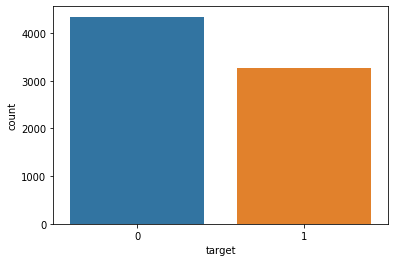

In [11]:
sns.countplot(x='target',data=df_train)

In [12]:
target1=len(df_train.loc[df_train.target==1])

In [13]:
target0=len(df_train.loc[df_train.target==0])

In [14]:
print('Target 0 as a percentage : {}'.format((target0)*100/(target1+target0)))

Target 0 as a percentage : 57.034020753973465


In [15]:
print('Target 1 as a percentage : {}'.format((target1)*100/(target1+target0)))

Target 1 as a percentage : 42.965979246026535


In [16]:
def getCombinedtext(df,text_column,target_column,target_value):
    """Generate a text combining the provided tweets """
    return " ".join(text for text in df.loc[df[target_column]==target_value][text_column].values)

In [17]:
def plotWordCloud(Text):
    """A form of visualizing the word frequency in a given text"""
    wordcloud = WordCloud(max_font_size=60,max_words=100,background_color='white').generate(Text)
    plt.imshow(wordcloud)

In [18]:
def viewText(Text):
    """Print a given text"""
    print(Text)

In [19]:
Text_Target0=getCombinedtext(df_train,'text','target',0)

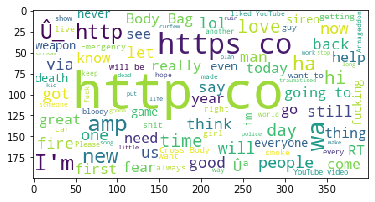

In [20]:
plotWordCloud(Text_Target0)

In [21]:
viewText(Text_Target0)

What's up man? I love fruits Summer is lovely My car is so fast What a goooooooaaaaaal!!!!!! this is ridiculous.... London is cool ;) Love skiing What a wonderful day! LOOOOOOL No way...I can't eat that shit Was in NYC last week! Love my girlfriend Cooool :) Do you like pasta? The end! We always try to bring the heavy. #metal #RT http://t.co/YAo1e0xngw Crying out for more! Set me ablaze On plus side LOOK AT THE SKY LAST NIGHT IT WAS ABLAZE http://t.co/qqsmshaJ3N @PhDSquares #mufc they've built so much hype around new acquisitions but I doubt they will set the EPL ablaze this season. Ablaze for you Lord :D Check these out: http://t.co/rOI2NSmEJJ http://t.co/3Tj8ZjiN21 http://t.co/YDUiXEfIpE http://t.co/LxTjc87KLS #nsfw on the outside you're ablaze and alive
but you're dead inside Had an awesome time visiting the CFC head office the ancop site and ablaze. Thanks to Tita Vida for taking care of us ?? SOOOO PUMPED FOR ABLAZE ???? @southridgelife I wanted to set Chicago ablaze with my preac

In [22]:
Text_Target1=getCombinedtext(df_train,'text','target',1)

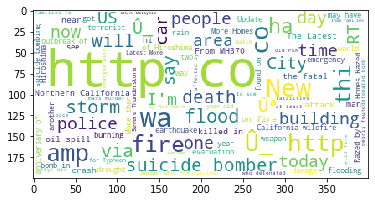

In [23]:
plotWordCloud(Text_Target1)

# Data Cleaning 

In [24]:
def remove_URL(text):
    """Removing URL"""
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

In [25]:
html_parser = HTMLParser()

def remove_html(text):
    """Escaping HTML Characters"""
    return html_parser.unescape(text)

In [27]:
def convertToLowercase(text):
    """Convert the overall text into lowercase"""
    return text.lower()

In [28]:
stopWords = set(stopwords.words('english'))

def remove_stopwords(words):
    """Removing stopwords"""
    return [word for word in words if word not in stopWords ]

In [29]:
# lemmatizer = WordNetLemmatizer()

# def lemmatization(words):
#     """Converting the word to its base form"""
# #     return [lemmatizer.lemmatize(word) for word in words]
#     return [Word(word).lemmatize() for word in words]
    

In [30]:
def lemmatize_with_postag(sentence):
    """Lemmatize each word with its post tag"""
    sent = TextBlob(sentence)
    tag_dict = {"J": 'a', 
                "N": 'n', 
                "V": 'v', 
                "R": 'r'}
    words_and_tags = [(w, tag_dict.get(pos[0], 'n')) for w, pos in sent.tags] 
    print(words_and_tags)
    lemmatized_list = [wd.lemmatize(tag) for wd, tag in words_and_tags]
    return " ".join(lemmatized_list)


In [31]:
def remove_punct(words):
    """Remove punctuations"""
    table=str.maketrans('','',string.punctuation)
    return [w.translate(table) for w in words]

In [32]:
def remove_numeric(words):
    """Filter the alphabetic words"""
    return [word for word in words if word.isalpha()]

In [33]:
# def correct_spellings(text):
#     corrected_text = []
#     misspelled_words = spell.unknown(text.split())
#     for word in text.split():
#         if word in misspelled_words:
#             corrected_text.append(spell.correction(word))
#         else:
#             corrected_text.append(word)
#     return " ".join(corrected_text)

In [35]:
def wordTokenize(text):
    """Split a text into words"""
    return word_tokenize(text)
    

In [36]:
df_train['text']=df_train['text'].apply(remove_html)
df_train['text']=df_train['text'].apply(remove_URL)
df_train['text']=df_train['text'].apply(convertToLowercase)
df_train['text']=df_train['text'].apply(wordTokenize)
df_train['text']=df_train['text'].apply(remove_punct)
df_train['text']=df_train['text'].apply(remove_numeric)
df_train['text']=df_train['text'].apply(remove_stopwords)

df_train['text']=df_train['text'].apply(lambda x : ' '.join(x))
df_train['text']=df_train['text'].apply(lemmatize_with_postag)
# df_train['text']=df_train['text'].apply(correct_spellings)

C:\Users\Acer\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:5: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  """


[('deeds', 'n'), ('reason', 'n'), ('earthquake', 'n'), ('may', 'n'), ('allah', 'v'), ('forgive', 'a'), ('us', 'n')]
[('forest', 'a'), ('fire', 'n'), ('near', 'n'), ('la', 'a'), ('ronge', 'n'), ('sask', 'n'), ('canada', 'n')]
[('residents', 'n'), ('asked', 'v'), ('shelter', 'a'), ('place', 'n'), ('notified', 'v'), ('officers', 'n'), ('evacuation', 'v'), ('shelter', 'a'), ('place', 'n'), ('orders', 'n'), ('expected', 'v')]
[('people', 'n'), ('receive', 'v'), ('wildfires', 'n'), ('evacuation', 'a'), ('orders', 'n'), ('california', 'v')]
[('got', 'v'), ('sent', 'a'), ('photo', 'n'), ('ruby', 'n'), ('alaska', 'n'), ('smoke', 'n'), ('wildfires', 'v'), ('pours', 'v'), ('school', 'n')]
[('rockyfire', 'n'), ('update', 'n'), ('california', 'n'), ('hwy', 'n'), ('closed', 'v'), ('directions', 'n'), ('due', 'a'), ('lake', 'v'), ('county', 'a'), ('fire', 'n'), ('cafire', 'n'), ('wildfires', 'n')]
[('flood', 'n'), ('disaster', 'n'), ('heavy', 'a'), ('rain', 'n'), ('causes', 'n'), ('flash', 'v'), ('fl

[('wisdomwed', 'v'), ('bonus', 'n'), ('minute', 'a'), ('daily', 'a'), ('habits', 'n'), ('could', 'n'), ('really', 'r'), ('improve', 'v'), ('life', 'n'), ('many', 'a'), ('already', 'r'), ('lifehacks', 'n')]
[('aftershock', 'n'), ('protect', 'n'), ('profit', 'n'), ('next', 'a'), ('global', 'a'), ('financial', 'a'), ('meltdown', 'n'), ('david', 'n'), ('wiedemer', 'n'), ('http', 'n')]
[('moment', 'n'), ('get', 'v'), ('scary', 'a'), ('roller', 'n'), ('coaster', 'n'), ('guy', 'n'), ('behind', 'n'), ('screaming', 'v'), ('bloody', 'a'), ('murder', 'n'), ('silverwood', 'n'), ('aftershock', 'n')]
[('aftershock', 'n'), ('streaming', 'v'), ('youtube', 'n')]
[('aftershock', 'n'), ('protect', 'n'), ('profit', 'n'), ('next', 'a'), ('global', 'a'), ('financial', 'a'), ('book', 'n'), ('esquireattire', 'n')]
[('sometimes', 'r'), ('face', 'n'), ('difficulties', 'n'), ('something', 'n'), ('wrong', 'a'), ('something', 'n'), ('right', 'a'), ('joel', 'n'), ('osteen', 'n')]
[('thing', 'n'), ('stands', 'v'), (

[('officially', 'r'), ('skipping', 'v'), ('fantasticfour', 'n'), ('hashtag', 'n'), ('getting', 'v'), ('annihilated', 'v'), ('reviews', 'n'), ('bummer', 'n')]
[('tomcatarts', 'n'), ('thus', 'r'), ('explaining', 'v'), ('annihilated', 'v'), ('case', 'n'), ('survivor', 'n'), ('evolved', 'v'), ('became', 'v'), ('godlike', 'a')]
[('completely', 'r'), ('annihilated', 'v'), ('cech', 'n'), ('paul', 'n'), ('keegan', 'a'), ('time', 'n'), ('alive', 'a')]
[('tomcatarts', 'n'), ('annihilated', 'v'), ('legion', 'n'), ('survivors', 'n'), ('imperfect', 'v'), ('hybrid', 'a'), ('project', 'n'), ('quickly', 'r'), ('formed', 'v'), ('new', 'a'), ('secret', 'a'), ('cell', 'n')]
[('sirbrandonknt', 'n'), ('exactly', 'r'), ('lesnarcena', 'v'), ('match', 'n'), ('summerslam', 'n'), ('last', 'a'), ('year', 'n'), ('great', 'a'), ('brock', 'n'), ('annihilated', 'v'), ('guy', 'n')]
[('cop', 'n'), ('pulls', 'n'), ('drunk', 'v'), ('driver', 'r'), ('safety', 'n'), ('seconds', 'n'), ('car', 'n'), ('hit', 'v'), ('train', 

[('pick', 'n'), ('fan', 'n'), ('army', 'n'), ('beyhive', 'n')]
[('one', 'n'), ('direction', 'n'), ('pick', 'n'), ('fan', 'n'), ('army', 'n'), ('directioners', 'n')]
[('seeing', 'v'), ('army', 'n'), ('whitewalkers', 'n'), ('first', 'a'), ('thing', 'n'), ('slightly', 'r'), ('intrigued', 'v'), ('got', 'v'), ('far', 'r')]
[('build', 'v'), ('kingdom', 'a'), ('lead', 'a'), ('army', 'n'), ('victory', 'a'), ('start', 'n'), ('g', 'n'), ('friend', 'n'), ('code', 'n'), ('lzktjnox', 'n')]
[('salvation', 'n'), ('army', 'n'), ('hosts', 'n'), ('rally', 'v'), ('reconnect', 'a'), ('fathers', 'n'), ('children', 'n'), ('salvation', 'n'), ('army', 'n'), ('hosting', 'v'), ('back', 'r'), ('school', 'n')]
[('vote', 'n'), ('directioners', 'n'), ('vs', 'v'), ('queens', 'n'), ('round', 'v'), ('billboard', 'r'), ('fanarmyfaceoff', 'n')]
[('build', 'a'), ('army', 'a'), ('dogs', 'n'), ('leader', 'n'), ('lion', 'n'), ('dogs', 'n'), ('fight', 'v'), ('like', 'n'), ('lion', 'n')]
[('show', 'n'), ('hero', 'a'), ('tv', 

[('black', 'a'), ('men', 'n'), ('nt', 'r'), ('make', 'v'), ('way', 'n'), ('white', 'a'), ('men', 'n'), ('black', 'a'), ('men', 'n'), ('getting', 'v'), ('attacked', 'v')]
[('cant', 'a'), ('believe', 'v'), ('fucking', 'v'), ('cis', 'n'), ('female', 'n'), ('going', 'v'), ('somehow', 'r'), ('claim', 'n'), ('offended', 'v'), ('transgendered', 'a'), ('female', 'n'), ('attacked', 'v'), ('media', 'n')]
[('israeli', 'a'), ('helicopters', 'n'), ('attacked', 'v'), ('civilians', 'n'), ('gaza', 'v'), ('completed', 'v'), ('exercises', 'n'), ('greece', 'v')]
[('christian', 'a'), ('attacked', 'v'), ('muslims', 'a'), ('temple', 'n'), ('mount', 'n'), ('waving', 'v'), ('israeli', 'a'), ('flag', 'n'), ('via', 'n'), ('pamela', 'n'), ('geller', 'n')]
[('christian', 'a'), ('attacked', 'v'), ('muslims', 'a'), ('temple', 'n'), ('mount', 'n'), ('waving', 'v'), ('israeli', 'a'), ('flag', 'n'), ('via', 'n'), ('pamela', 'n'), ('geller', 'n')]
[('christian', 'a'), ('attacked', 'v'), ('muslims', 'a'), ('temple', 'n'

[('fedex', 'n'), ('longer', 'r'), ('transport', 'v'), ('bioterror', 'n'), ('germs', 'n'), ('wake', 'v'), ('anthrax', 'n'), ('lab', 'n'), ('mishaps', 'n')]
[('usatoday', 'a'), ('today', 'n'), ('frontpage', 'n'), ('bioterror', 'n'), ('lab', 'n'), ('faced', 'v'), ('secret', 'a'), ('sanctions', 'n'), ('rickperry', 'v'), ('nt', 'r'), ('make', 'v'), ('cut', 'n')]
[('fedex', 'n'), ('longer', 'r'), ('transport', 'v'), ('bioterror', 'n'), ('germs', 'n'), ('wake', 'v'), ('anthrax', 'n'), ('lab', 'n'), ('mishaps', 'n'), ('via', 'n'), ('usatoday', 'a')]
[('biolab', 'n'), ('safety', 'n'), ('concerns', 'n'), ('grow', 'v'), ('fedex', 'n'), ('stops', 'n'), ('transporting', 'v'), ('certain', 'a'), ('specimens', 'n'), ('research', 'n'), ('facilities', 'n'), ('dumbfounded', 'v'), ('action', 'n')]
[('fight', 'a'), ('bioterrorism', 'n'), ('sir', 'n')]
[('liked', 'v'), ('youtube', 'a'), ('video', 'n'), ('fema', 'a'), ('region', 'n'), ('iii', 'n'), ('targeted', 'v'), ('bioterrorism', 'n'), ('nasa', 'n'), ('j

[('hit', 'a'), ('foot', 'n'), ('toe', 'n'), ('bleeding', 'n')]
[('kingnaruto', 'n'), ('long', 'r'), ('see', 'v'), ('madara', 'a'), ('bleeding', 'v'), ('good', 'a')]
[('keep', 'v'), ('thinking', 'n'), ('stepped', 'a'), ('broken', 'a'), ('glass', 'n'), ('pun', 'n'), ('tak', 'n'), ('sedar', 'n'), ('nt', 'n'), ('feel', 'n'), ('pain', 'n'), ('also', 'r'), ('bleeding', 'v'), ('shit', 'n')]
[('ears', 'n'), ('bleeding', 'v')]
[('waited', 'v'), ('hours', 'n'), ('get', 'v'), ('cab', 'a'), ('feet', 'n'), ('bleeding', 'v')]
[('cute', 'n'), ('dinner', 'n'), ('date', 'n'), ('til', 'n'), ('cams', 'n'), ('nose', 'a'), ('starts', 'n'), ('bleeding', 'v')]
[('uptownjorge', 'a'), ('head', 'n'), ('like', 'n'), ('yo', 'n'), ('nose', 'r'), ('bleeding', 'v')]
[('bleeding', 'v'), ('silence', 'n'), ('feel', 'n'), ('safer', 'n'), ('violence', 'n')]
[('fell', 'v'), ('someone', 'n'), ('back', 'r'), ('hit', 'a'), ('head', 'n'), ('concrete', 'n'), ('bleeding', 'v'), ('n', 'a'), ('shit', 'n')]
[('katramsland', 'v'), 

[('rip', 'n'), ('blood', 'n')]
[('chiefcg', 'n'), ('nah', 'n'), ('young', 'a'), ('blood', 'n'), ('cook', 'n'), ('gone', 'v'), ('cut', 'a'), ('haha', 'n')]
[('wall', 'n'), ('invincible', 'a'), ('history', 'n'), ('blood', 'n'), ('dance', 'n'), ('floor', 'n')]
[('broke', 'v'), ('nail', 'a'), ('real', 'a'), ('fake', 'a'), ('morning', 'n'), ('blood', 'n'), ('ah', 'n'), ('hurts', 'v'), ('ideas', 'n'), ('treat', 'n'), ('help', 'v'), ('pretty', 'r'), ('please', 'v')]
[('stars', 'n'), ('reviewers', 'n'), ('dragon', 'v'), ('blood', 'n'), ('boxset', 'n'), ('lindsay', 'v'), ('buroker', 'n'), ('kindle', 'n')]
[('blood', 'n'), ('group', 'n'), ('associated', 'v'), ('gastric', 'a'), ('carcinoma', 'n'), ('says', 'v'), ('text', 'a'), ('book', 'n'), ('another', 'n'), ('fragile', 'a'), ('gene', 'n'), ('body', 'n')]
[('friend', 'n'), ('like', 'n'), ('blood', 'n'), ('beside', 'n'), ('us', 'n'), ('always', 'r'), ('come', 'v'), ('wounded', 'v')]
[('gone', 'v'), ('get', 'v'), ('get', 'v'), ('blood', 'n')]
[('p

[('new', 'a'), ('ladies', 'n'), ('shoulder', 'v'), ('tote', 'a'), ('handbag', 'n'), ('faux', 'n'), ('leather', 'n'), ('hobo', 'n'), ('purse', 'n'), ('cross', 'n'), ('body', 'n'), ('bag', 'n'), ('womens', 'v'), ('rt', 'n')]
[('trjdavis', 'n'), ('bruh', 'n'), ('wan', 'n'), ('na', 'n'), ('fight', 'a'), ('meet', 'n'), ('cage', 'n'), ('bro', 'v'), ('better', 'a'), ('find', 'n'), ('dealing', 'a'), ('end', 'n'), ('body', 'n'), ('bag', 'n')]
[('new', 'a'), ('ladies', 'n'), ('shoulder', 'v'), ('tote', 'a'), ('handbag', 'n'), ('faux', 'n'), ('leather', 'n'), ('hobo', 'n'), ('purse', 'n'), ('cross', 'n'), ('body', 'n'), ('bag', 'n'), ('womens', 'v'), ('full', 'a')]
[('auth', 'r'), ('louis', 'a'), ('vuitton', 'n'), ('brown', 'n'), ('saumur', 'a'), ('cross', 'n'), ('body', 'n'), ('shoulder', 'n'), ('bag', 'n'), ('monogram', 'n'), ('full', 'a')]
[('check', 'n'), ('vintage', 'n'), ('longaberger', 'r'), ('floral', 'a'), ('fabric', 'n'), ('shoulder', 'n'), ('cross', 'n'), ('body', 'n'), ('bag', 'v'), (

[('carajdeievingnc', 'n'), ('bomb', 'n'), ('impact', 'n'), ('ratio', 'n'), ('hit', 'v'), ('beyond', 'n'), ('kyle', 'a'), ('js', 'n')]
[('swellyjetevo', 'n'), ('disneyland', 'n'), ('tacos', 'n'), ('bomb', 'n')]
[('flat', 'a'), ('bomb', 'n'), ('whatcanthedo', 'v')]
[('would', 'n'), ('look', 'v'), ('like', 'n'), ('hiroshima', 'n'), ('bomb', 'n'), ('hit', 'v'), ('detroit', 'a'), ('thursday', 'n'), ('marks', 'n'), ('anniversary', 'v'), ('united', 'a')]
[('soul', 'n'), ('food', 'n'), ('sound', 'n'), ('bomb', 'n'), ('right', 'n')]
[('bomb', 'n'), ('appropriate', 'a'), ('seen', 'v'), ('family', 'n'), ('jamaicans', 'n'), ('love', 'v'), ('shout', 'n'), ('bullets', 'n')]
[('hatchetwielding', 'v'), ('gunman', 'a'), ('pepper', 'n'), ('spray', 'n'), ('fake', 'n'), ('bomb', 'n')]
[('oops', 'n'), ('h', 'v'), ('bomb', 'n'), ('lost', 'v'), ('miles', 'n'), ('okinawan', 'r'), ('coast', 'n'), ('fell', 'v'), ('ship', 'n')]
[('guardian', 'a'), ('view', 'n'), ('hiroshima', 'n'), ('legacy', 'n'), ('still', 'r'

[('rocky', 'a'), ('fire', 'n'), ('burning', 'v'), ('northern', 'a'), ('california', 'n'), ('still', 'r'), ('threatening', 'v'), ('buildings', 'n'), ('largest', 'a'), ('state', 'n')]
[('high', 'a'), ('skies', 'n'), ('burning', 'v'), ('buildings', 'n'), ('nowplaying', 'v')]
[('messi', 'n'), ('tattoos', 'n'), ('ca', 'n'), ('nt', 'v'), ('donate', 'v'), ('blood', 'n'), ('ronaldo', 'n'), ('runs', 'v'), ('burning', 'v'), ('buildings', 'n'), ('save', 'v'), ('dogs', 'n'), ('respect', 'v')]
[('probably', 'r'), ('skip', 'n'), ('basic', 'a'), ('life', 'n'), ('maintenance', 'n'), ('things', 'n'), ('days', 'n'), ('cut', 'v'), ('burning', 'a'), ('buildings', 'n'), ('people', 'n'), ('screaming', 'v'), ('streets', 'n')]
[('foxnews', 'n'), ('one', 'n'), ('rioting', 'v'), ('burning', 'n'), ('buildings', 'n'), ('looting', 'v')]
[('joshcorman', 'n'), ('infosec', 'v'), ('rather', 'r'), ('knew', 'a'), ('firefighter', 'n'), ('days', 'n'), ('often', 'r'), ('run', 'v'), ('burning', 'v'), ('buildings', 'n'), ('d

[('minsuwoongs', 'n'), ('completely', 'r'), ('understand', 'v'), ('woke', 'n'), ('like', 'n'), ('minutes', 'n'), ('ago', 'r'), ('im', 'v'), ('burning', 'v')]
[('ika', 'a'), ('tuning', 'v'), ('soup', 'n'), ('diet', 'a'), ('recipes', 'n'), ('fat', 'a'), ('burning', 'v'), ('soup', 'n'), ('recipes', 'n'), ('fat', 'v'), ('burning', 'v'), ('soup', 'n'), ('diet', 'a'), ('recip', 'n')]
[('burning', 'v'), ('man', 'n'), ('tickets', 'n'), ('vehicle', 'n'), ('pass', 'v'), ('full', 'a'), ('read', 'n'), ('ebay', 'n')]
[('last', 'a'), ('days', 'n'), ('summer', 'n'), ('supposed', 'v'), ('fun', 'n'), ('fun', 'n'), ('accidentally', 'r'), ('burning', 'v'), ('arm', 'n'), ('hair', 'n'), ('playing', 'v'), ('w', 'n'), ('lighter', 'r')]
[('killing', 'v'), ('black', 'a'), ('babies', 'n'), ('planned', 'v'), ('parenthood', 'n'), ('demonstrations', 'n'), ('looting', 'v'), ('pp', 'n'), ('burning', 'n'), ('buildings', 'n'), ('black', 'a'), ('babies', 'n'), ('lives', 'v'), ('matter', 'n')]
[('mmmmmm', 'n'), ('burnin

[('best', 'a'), ('special', 'a'), ('report', 'n'), ('metrics', 'n'), ('correlate', 'v'), ('best', 'a'), ('propertycasualty', 'n'), ('marketwatch', 'n')]
[('took', 'v'), ('way', 'n'), ('longer', 'r'), ('expected', 'v')]
[('still', 'r'), ('nt', 'r'), ('know', 'a'), ('independence', 'n'), ('day', 'n'), ('social', 'a'), ('casualty', 'n'), ('rowyso', 'a'), ('setlist', 'a'), ('songs', 'n'), ('would', 'n'), ('good', 'v'), ('live', 'n')]
[('need', 'n'), ('stop', 'v'), ('scasualty', 'n')]
[('rt', 'v'), ('greenharvard', 'n'), ('documenting', 'v'), ('climate', 'n'), ('change', 'n'), ('first', 'r'), ('major', 'a'), ('casualty', 'n'), ('via', 'n'), ('greenharvard', 'n')]
[('social', 'a'), ('casualty', 'n')]
[('canceling', 'v'), ('deal', 'a'), ('warships', 'n'), ('france', 'n'), ('agrees', 'v'), ('repay', 'a'), ('russia', 'n'), ('via', 'n'), ('nytimes', 'n')]
[('social', 'a'), ('casualty', 'n'), ('mtvhottest', 'a')]
[('conning', 'v'), ('builds', 'n'), ('strong', 'a'), ('case', 'n'), ('portfolio', 'n

[('fuck', 'n'), ('neil', 'n'), ('go', 'v'), ('fall', 'v'), ('cliff', 'n'), ('something', 'n'), ('yr', 'n')]
[('beat', 'n'), ('heat', 'n'), ('today', 'n'), ('kill', 'v'), ('cliff', 'a'), ('free', 'a'), ('fall', 'n'), ('pick', 'n'), ('cold', 'n'), ('drink', 'n'), ('today', 'n'), ('tough', 'a'), ('crossfit', 'n')]
[('news', 'n'), ('flash', 'n'), ('decent', 'n'), ('billers', 'n'), ('promoted', 'v'), ('manager', 'n'), ('let', 'n'), ('know', 'n'), ('want', 'v'), ('watch', 'n'), ('billings', 'n'), ('fall', 'v'), ('cliff', 'n'), ('humble', 'n')]
[('like', 'n'), ('fall', 'n'), ('cliff', 'n'), ('grabbing', 'v'), ('hand', 'n'), ('palms', 'n'), ('sweaty', 'v'), ('bruh', 'n')]
[('regress', 'n'), ('slip', 'n'), ('fall', 'n'), ('cliff', 'n')]
[('ok', 'a'), ('peace', 'n'), ('hope', 'v'), ('fall', 'n'), ('cliff', 'n'), ('along', 'n'), ('dignity', 'n')]
[('reading', 'v'), ('go', 'v'), ('accidentally', 'r'), ('fall', 'v'), ('cliff', 'n'), ('mate', 'n')]
[('u', 'a'), ('faved', 'v'), ('hope', 'n'), ('fall'

[('even', 'r'), ('stars', 'n'), ('moon', 'v'), ('collide', 'a'), ('oh', 'n'), ('oh', 'a'), ('never', 'r'), ('want', 'v'), ('back', 'a'), ('life', 'n'), ('take', 'n'), ('words', 'n')]
[('nowplaying', 'v'), ('playlist', 'a'), ('jazz', 'n'), ('hiphop', 'n'), ('collide', 'n'), ('tidalhifi', 'n')]
[('vancouver', 'r'), ('host', 'n'), ('electronic', 'a'), ('art', 'n'), ('events', 'n'), ('including', 'v'), ('mutekmontreal', 'n')]
[('worlds', 'n'), ('collide', 'v'), ('american', 'a'), ('family', 'n'), ('takes', 'v'), ('britain', 'v'), ('isle', 'a'), ('man', 'n'), ('new', 'a'), ('tlc', 'n'), ('show', 'n'), ('suddenly', 'r'), ('royal', 'v'), ('via', 'n'), ('people', 'n')]
[('houston', 'n'), ('nyc', 'n'), ('collide', 'v'), ('pageparkescorp', 'a'), ('chloeunguyen', 'n'), ('laurensicle', 'n'), ('tiaramarei', 'n'), ('gemma', 'n')]
[('setlist', 'n'), ('collideworship', 'n'), ('past', 'n'), ('sunday', 'a'), ('powerful', 'a'), ('song', 'n'), ('favorite', 'n')]
[('thedoolinggroup', 'n'), ('injured', 'a')

[('crash', 'n'), ('test', 'n'), ('trailer', 'n'), ('paul', 'n'), ('scheer', 'n'), ('rob', 'n'), ('huebel', 'n'), ('comedy', 'n'), ('special', 'a'), ('recorded', 'v')]
[('spicybreads', 'n'), ('coxytown', 'v'), ('tried', 'a'), ('downloading', 'n'), ('crashed', 'v'), ('tutorial', 'a')]
[('maj', 'n'), ('muzzamil', 'n'), ('pilot', 'n'), ('offr', 'n'), ('crashed', 'v'), ('near', 'n'), ('mansehra', 'n'), ('today', 'n')]
[('bin', 'n'), ('laden', 'a'), ('family', 'n'), ('plane', 'n'), ('crashed', 'v'), ('avoiding', 'v'), ('microlight', 'n'), ('landi', 'n'), ('peritoengrafoscopia', 'n')]
[('son', 'n'), ('nt', 'r'), ('sleep', 'a'), ('night', 'n'), ('finally', 'r'), ('laid', 'v'), ('bed', 'n'), ('crashed', 'v')]
[('knobhead', 'a'), ('bin', 'n'), ('laden', 'a'), ('family', 'n'), ('plane', 'n'), ('crashed', 'v'), ('avoiding', 'v'), ('microlight', 'n'), ('landing', 'n')]
[('bin', 'n'), ('laden', 'a'), ('family', 'n'), ('plane', 'n'), ('crashed', 'v'), ('avoiding', 'v'), ('microlight', 'n'), ('landing

[('rite', 'n'), ('man', 'n'), ('tlk', 'v'), ('widout', 'n'), ('nuh', 'a'), ('curfew', 'n'), ('long', 'a'), ('side', 'n'), ('aka', 'n'), ('cum', 'n'), ('fi', 'n'), ('steal', 'n'), ('di', 'v'), ('show', 'v'), ('itz', 'a'), ('rubbery', 'n'), ('di', 'n'), ('whole', 'a'), ('dem', 'n'), ('fi', 'n'), ('knw', 'n'), ('sound', 'n'), ('music', 'n')]
[('dont', 'r'), ('even', 'r'), ('come', 'v'), ('worried', 'a'), ('curfew', 'n')]
[('got', 'v'), ('whole', 'a'), ('curfew', 'n')]
[('hours', 'n'), ('late', 'a'), ('curfew', 'n'), ('pray', 'v'), ('dog', 'a'), ('nt', 'a'), ('bark', 'n'), ('unlocking', 'a'), ('door', 'n')]
[('da', 'n'), ('judge', 'n'), ('gave', 'v'), ('dis', 'a'), ('girl', 'n'), ('curfew', 'n')]
[('beginning', 'v'), ('summer', 'n'), ('mom', 'n'), ('made', 'v'), ('curfew', 'n'), ('back', 'r'), ('never', 'r'), ('go', 'v'), ('wonders', 'n'), ('always', 'r'), ('home', 'v')]
[('charlie', 'n'), ('lim', 'a'), ('start', 'n'), ('sunday', 'n'), ('curfew', 'n'), ('leh', 'n')]
[('u', 'a'), ('bombed',

[('miss', 'r'), ('longer', 'r'), ('hairbut', 'a'), ('dead', 'a'), ('anyways', 'n'), ('nt', 'r'), ('even', 'r'), ('hair', 'n')]
[('cjbanning', 'v'), ('argsuppose', 'a'), ('preborn', 'n'), ('attained', 'v'), ('individl', 'a'), ('rightsgenerally', 'r'), ('courtof', 'a'), ('law', 'n'), ('forbids', 'n'), ('killing', 'v'), ('unless', 'n'), ('dead', 'a'), ('person', 'n'), ('something', 'n')]
[('remember', 'v'), ('time', 'n'), ('goku', 'n'), ('gave', 'v'), ('life', 'n'), ('dead', 'a'), ('birb', 'n'), ('hell', 'n'), ('goku', 'n')]
[('naaa', 'a'), ('bee', 'n'), ('dead', 'a'), ('like', 'n'), ('legit', 'a'), ('zombie', 'n'), ('feel', 'n'), ('every', 'n'), ('sore', 'n'), ('part', 'n'), ('body', 'n')]
[('happened', 'v'), ('get', 'v'), ('road', 'n'), ('right', 'n'), ('behind', 'n'), ('buses', 'n'), ('dead', 'v'), ('serious', 'a')]
[('lmfao', 'n'), ('fucking', 'v'), ('luis', 'a'), ('hhahaha', 'a'), ('im', 'n'), ('dead', 'a')]
[('watched', 'v'), ('emmerdale', 'a'), ('nd', 'a'), ('nt', 'n'), ('know', 'v

[('reunion', 'n'), ('debris', 'n'), ('missing', 'v'), ('malaysia', 'n'), ('flight', 'n')]
[('experts', 'n'), ('leave', 'v'), ('lab', 'a'), ('malaysia', 'n'), ('confirms', 'n'), ('debris', 'v')]
[('malaysia', 'n'), ('confirms', 'v'), ('plane', 'n'), ('debris', 'n'), ('washed', 'v'), ('reunion', 'n'), ('island', 'n'), ('flight', 'n')]
[('kamindoz', 'n'), ('reuters', 'n'), ('debris', 'v'), ('confirmed', 'v'), ('relatives', 'n'), ('hope', 'v'), ('discovery', 'n'), ('crash', 'n')]
[('plane', 'n'), ('debris', 'n'), ('discovered', 'v'), ('reunion', 'n'), ('island', 'n'), ('belongs', 'n'), ('flight', 'n'), ('malaysian', 'n'), ('pm', 'n')]
[('debris', 'n'), ('confirmed', 'v'), ('relatives', 'n'), ('hope', 'v'), ('discovery', 'n'), ('crash', 'n'), ('site', 'n'), ('malaysian', 'a'), ('officials', 'n'), ('confirm', 'v'), ('breakth', 'n')]
[('abc', 'n'), ('aircraft', 'n'), ('debris', 'n'), ('found', 'v'), ('la', 'a'), ('reunion', 'n'), ('missing', 'v'), ('malaysia', 'n'), ('airlines', 'n'), ('abc',

[('first', 'r'), ('counter', 'r'), ('league', 'a'), ('game', 'n'), ('another', 'n'), ('orianna', 'n'), ('happened', 'v'), ('demolish', 'a'), ('xd', 'n'), ('totally', 'r'), ('appreciate', 'a'), ('people', 'n'), ('play', 'v')]
[('think', 'n'), ('going', 'v'), ('demolish', 'a'), ('drake', 'n'), ('house', 'n'), ('ghostwriting', 'v'), ('shit', 'n'), ('know', 'v'), ('rihanna', 'n'), ('lives', 'n'), ('next', 'n'), ('door', 'n')]
[('added', 'v'), ('video', 'n'), ('youtube', 'n'), ('playlist', 'n'), ('dan', 'n'), ('arin', 'n'), ('demolish', 'a'), ('giant', 'a'), ('gummy', 'n'), ('bear', 'n'), ('grumpout', 'n')]
[('nah', 'r'), ('srsly', 'r'), ('u', 'a'), ('demolish', 'a'), ('ur', 'n'), ('partner', 'n'), ('face', 'v'), ('start', 'n'), ('dribbling', 'v'), ('nostrils', 'n'), ('stop', 'v'), ('ask', 'n'), ('urself', 'n'), ('whether', 'n'), ('really', 'r'), ('worth', 'a'), ('embarrassment', 'n')]
[('charminar', 'n'), ('demolish', 'a'), ('falling', 'v'), ('state', 'n'), ('anyway', 'r'), ('take', 'v'), 

[('breakfast', 'n'), ('links', 'n'), ('work', 'v'), ('home', 'n'), ('derailed', 'v'), ('empty', 'a'), ('train', 'n'), ('derailed', 'v'), ('smithsonian', 'a'), ('morning', 'n'), ('suspending', 'v'), ('ser', 'n')]
[('eve', 'r'), ('jon', 'n'), ('stewart', 'a'), ('leaving', 'v'), ('daily', 'a'), ('show', 'n'), ('wmata', 'n'), ('honored', 'v'), ('letting', 'v'), ('another', 'n'), ('train', 'n'), ('get', 'n'), ('derailed', 'v'), ('crippling', 'a'), ('service', 'n')]
[('going', 'v'), ('starbs', 'a'), ('degrees', 'n'), ('part', 'n'), ('metro', 'n'), ('derailed', 'v'), ('beautiful', 'a'), ('morning', 'n'), ('washington', 'n'), ('dc', 'n')]
[('oh', 'n'), ('wait', 'n'), ('expected', 'v'), ('go', 'v'), ('totally', 'r'), ('different', 'a'), ('route', 'n'), ('ls', 'n'), ('derailed', 'v'), ('another', 'n'), ('barely', 'r'), ('passing', 'v'), ('grade', 'n'), ('required', 'v'), ('course', 'n'), ('super', 'n')]
[('adamtuss', 'n'), ('car', 'n'), ('derailed', 'v'), ('series', 'n'), ('chance', 'n'), ('used

[('kaiseiw', 'a'), ('people', 'n'), ('like', 'n'), ('whole', 'a'), ('people', 'n'), ('named', 'v'), ('desolation', 'n')]
[('desperation', 'n'), ('dislocation', 'n'), ('separation', 'n'), ('condemnation', 'n'), ('revelation', 'n'), ('temptation', 'n'), ('isolation', 'n'), ('desolation', 'n'), ('let', 'v'), ('go', 'v'), ('find', 'v'), ('away', 'r')]
[('hobbit', 'n'), ('desolation', 'n'), ('smaug', 'v'), ('bilingual', 'a')]
[('winter', 'n'), ('desolation', 'n'), ('death', 'n'), ('also', 'r'), ('tumblr', 'v'), ('al', 'a'), ('necro', 'a'), ('reviews', 'n'), ('interviews', 'n')]
[('np', 'a'), ('agalloch', 'a'), ('desolation', 'n'), ('song', 'n')]
[('imagini', 'n'), ('noi', 'n'), ('si', 'n'), ('clipuri', 'n'), ('hobbit', 'n'), ('desolation', 'n'), ('smaug', 'n'), ('cliptv', 'n'), ('desolationofsmaug', 'n'), ('poze', 'n'), ('thehobbit', 'n')]
[('fear', 'n'), ('panic', 'a'), ('air', 'n'), ('want', 'v'), ('free', 'a'), ('desolation', 'n'), ('despair', 'n'), ('feel', 'v'), ('like', 'n'), ('everyt

[('nuke', 'a'), ('please', 'n'), ('target', 'n'), ('hilversum', 'a'), ('please', 'n'), ('detonate', 'n'), ('meters', 'n'), ('surface', 'v')]
[('opticscumper', 'n'), ('yo', 'n'), ('u', 'a'), ('sexy', 'n')]
[('channelstv', 'a'), ('terrorism', 'n'), ('war', 'n'), ('army', 'n'), ('intel', 'n'), ('agents', 'n'), ('counter', 'v'), ('moves', 'n'), ('detonate', 'v'), ('bombs', 'n')]
[('apollo', 'r'), ('brown', 'a'), ('detonate', 'n'), ('f', 'n'), ('mop', 'v'), ('hhbu', 'n')]
[('tinyjecht', 'n'), ('another', 'n'), ('standuser', 'n'), ('detonate', 'n'), ('killer', 'n'), ('queen', 'n')]
[('apollo', 'r'), ('brown', 'a'), ('detonate', 'n'), ('feat', 'n'), ('mop', 'n'), ('mello', 'a'), ('music', 'n'), ('group', 'n'), ('via', 'n'), ('soundcloud', 'n')]
[('detonate', 'n'), ('feat', 'n'), ('mop', 'n'), ('apollo', 'v'), ('brown', 'a')]
[('woundedpigeon', 'n'), ('detonate', 'n'), ('apollobrown', 'n'), ('ft', 'n'), ('mop', 'n')]
[('mwnhappy', 'a'), ('message', 'n'), ('self', 'n'), ('detonate', 'n')]
[('de

[('first', 'r'), ('staining', 'v'), ('attempt', 'n'), ('disaster', 'n')]
[('dealing', 'v'), ('disaster', 'n')]
[('want', 'n'), ('go', 'v'), ('back', 'r'), ('vegas', 'r'), ('feel', 'n'), ('like', 'n'), ('would', 'n'), ('disaster', 'v'), ('lol', 'r'), ('much', 'a'), ('money', 'n'), ('would', 'n'), ('need', 'v'), ('brought', 'n')]
[('blue', 'n'), ('bell', 'n'), ('may', 'n'), ('close', 'v'), ('return', 'n'), ('listeria', 'a'), ('disaster', 'n'), ('hot', 'a'), ('theneeds', 'n'), ('recipes', 'n')]
[('jeff', 'n'), ('locke', 'n'), ('train', 'n'), ('wreck', 'n'), ('fin', 'n'), ('disaster', 'n'), ('fortunately', 'r'), ('pirates', 'v'), ('acquired', 'v'), ('top', 'a'), ('quality', 'n'), ('starter', 'n'), ('ja', 'n'), ('oh', 'n'), ('wait', 'n'), ('blowltan', 'n')]
[('metepec', 'n'), ('mexico', 'n'), ('night', 'n'), ('disaster', 'n'), ('e', 'v'), ('oficial', 'a'), ('nitclub', 'n')]
[('disaster', 'n'), ('averted', 'v'), ('police', 'n'), ('kill', 'v'), ('gunman', 'a'), ('hoax', 'n'), ('device', 'n'),

[('little', 'a'), ('gecko', 'a'), ('chillin', 'n'), ('garden', 'n'), ('ended', 'v'), ('helping', 'v'), ('suspected', 'a'), ('might', 'n'), ('drown', 'v')]
[('save', 'v'), ('self', 'n'), ('nt', 'a'), ('let', 'v'), ('drown', 'v')]
[('carry', 'a'), ('things', 'n'), ('inside', 'n'), ('one', 'n'), ('else', 'r'), ('see', 'v'), ('hold', 'a'), ('us', 'n'), ('like', 'n'), ('anchors', 'n'), ('drown', 'v'), ('us', 'n'), ('sea', 'n')]
[('nowplaying', 'v'), ('porcupine', 'n'), ('tree', 'a'), ('drown', 'a'), ('live', 'a'), ('listen', 'n'), ('live', 'v')]
[('lowkey', 'a'), ('already', 'r'), ('know', 'v'), ('gon', 'v'), ('na', 'n'), ('drown', 'a'), ('school', 'n'), ('year', 'n')]
[('chromsucks', 'n'), ('nt', 'v'), ('drown', 'a')]
[('throw', 'a'), ('water', 'n'), ('drown', 'v'), ('last', 'a'), ('words', 'n'), ('choke', 'v')]
[('drown', 'n'), ('k', 'n'), ('ca', 'n'), ('nt', 'v'), ('swim', 'n')]
[('days', 'n'), ('drown', 'v'), ('tears', 'n'), ('nt', 'a'), ('let', 'n'), ('get', 'v')]
[('ca', 'n'), ('nt', 

[('feel', 'n'), ('like', 'n'), ('drowning', 'v'), ('inside', 'n'), ('body', 'n')]
[('drowning', 'v'), ('hw', 'n'), ('wo', 'n'), ('going', 'v'), ('swim', 'v'), ('ohlordy', 'a')]
[('nwspocatello', 'r'), ('far', 'r'), ('brunt', 'a'), ('storm', 'a'), ('north', 'a'), ('grayed', 'v'), ('w', 'n'), ('dust', 'n'), ('rain', 'n'), ('n', 'n'), ('blue', 'a'), ('sky', 'n'), ('interspersed', 'v'), ('w', 'n'), ('clouds', 'n')]
[('poor', 'a'), ('sods', 'n'), ('arriving', 'v'), ('amman', 'n'), ('yesterday', 'n'), ('dust', 'v'), ('storm', 'n'), ('diverted', 'v'), ('ben', 'a'), ('gurion', 'n'), ('airport', 'n')]
[('kids', 'n'), ('disappear', 'v'), ('dust', 'a'), ('storm', 'n'), ('atmospheric', 'n'), ('aussie', 'n'), ('thriller', 'n'), ('rt', 'n'), ('newzsacramento', 'n')]
[('nasa', 'a'), ('modis', 'n'), ('image', 'n'), ('dust', 'n'), ('storm', 'n'), ('morocco', 'n'), ('straits', 'n'), ('gibraltar', 'v'), ('duststorm', 'n')]
[('totoooooo', 'n'), ('totoooooooooo', 'n'), ('historicalmages', 'v'), ('dust', 'v

[('mapmyrun', 'r'), ('electrocuted', 'v'), ('way', 'n'), ('round', 'n'), ('map', 'v'), ('sure', 'a'), ('looks', 'n'), ('like', 'n')]
[('loving', 'v'), ('classic', 'a'), ('barn', 'n'), ('shot', 'n'), ('may', 'n'), ('may', 'n'), ('got', 'v'), ('electrocuted', 'a'), ('got', 'v'), ('stung', 'a'), ('times', 'n'), ('stepped', 'v')]
[('got', 'r'), ('electrocuted', 'v'), ('last', 'a'), ('night', 'n'), ('work', 'n'), ('first', 'r'), ('time', 'n'), ('life', 'n'), ('shit', 'v'), ('weird', 'a')]
[('bbcnews', 'n'), ('mwlippert', 'v'), ('southkorea', 'a'), ('dogs', 'n'), ('prepared', 'v'), ('electrocutedboiling', 'v'), ('waterfur', 'n'), ('machine', 'n'), ('still', 'r'), ('alive', 'a')]
[('thought', 'v'), ('let', 'n'), ('know', 'v'), ('probably', 'r'), ('good', 'a'), ('idea', 'n'), ('plug', 'n'), ('hairdryer', 'n'), ('wet', 'n'), ('electrocuted', 'v')]
[('mt', 'a'), ('earthsvoice', 'n'), ('treatment', 'n'), ('tigers', 'n'), ('china', 'v'), ('appalling', 'v'), ('electrocuted', 'v'), ('front', 'a'), (

[('beyond', 'n'), ('stressed', 'v'), ('beyond', 'n'), ('hysteria', 'n'), ('grey', 'a'), ('misty', 'a'), ('indifference', 'n'), ('complete', 'a'), ('shutdown', 'n'), ('emergency', 'n'), ('services', 'n'), ('brain', 'n')]
[('services', 'n'), ('returning', 'v'), ('normal', 'a'), ('southline', 'a'), ('medical', 'a'), ('emergency', 'n'), ('yennora', 'n'), ('urgent', 'a'), ('track', 'n'), ('equipment', 'n'), ('repairs', 'n'), ('cabramatta', 'n'), ('earlier', 'r')]
[('hi', 'n'), ('thought', 'v'), ('recognised', 'v'), ('smile', 'a'), ('believe', 'v'), ('emergency', 'n'), ('services', 'n'), ('best', 'r'), ('performing', 'v'), ('arts', 'n'), ('followers', 'n'), ('simon', 'v')]
[('doctors', 'n'), ('nurses', 'v'), ('new', 'a'), ('pediatric', 'a'), ('emergency', 'n'), ('department', 'n'), ('specialized', 'v'), ('child', 'n'), ('services', 'n')]
[('missionhills', 'n'), ('ca', 'n'), ('nursing', 'v'), ('registered', 'a'), ('nurse', 'a'), ('emergency', 'n'), ('department', 'n'), ('full', 'a'), ('time',

[('rocky', 'a'), ('fire', 'n')]
[('ahrar', 'n'), ('al', 'n'), ('sham', 'n'), ('negotiations', 'n'), ('iran', 'v'), ('al', 'r'), ('zabadani', 'n'), ('wanted', 'v'), ('sunnis', 'n'), ('evacuated', 'v'), ('al', 'n'), ('zabadani', 'n')]
[('entire', 'a'), ('town', 'n'), ('roosevelt', 'n'), ('wash', 'n'), ('evacuated', 'v'), ('wildfire', 'n')]
[('katunews', 'n'), ('remains', 'v'), ('closed', 'a'), ('brush', 'n'), ('fire', 'n'), ('burns', 'n'), ('acres', 'n')]
[('good', 'a'), ('thing', 'n'), ('actually', 'r'), ('legit', 'a'), ('fire', 'n'), ('mall', 'n'), ('nobody', 'n'), ('evacuated', 'v')]
[('seclusion', 'n'), ('class', 'n'), ('evacuated', 'v'), ('child', 'a'), ('left', 'v'), ('alone', 'a'), ('class', 'n'), ('force', 'n'), ('compliance', 'n'), ('morevoices', 'n')]
[('rocky', 'a'), ('fire', 'n'), ('northern', 'a'), ('california', 'n'), ('swells', 'n'), ('acres', 'n'), ('evacuated', 'v'), ('portland', 'n'), ('phoenix', 'n'), ('miami', 'n'), ('atlanta', 'v'), ('casper', 'n')]
[('got', 'v'), ('

[('lunasagalle', 'n'), ('synapsenkotze', 'n'), ('exploded', 'v'), ('bean', 'a'), ('bastard', 'n')]
[('dating', 'v'), ('meet', 'a'), ('sex', 'n'), ('hot', 'a'), ('teen', 'a'), ('ass', 'n'), ('exploded', 'v'), ('fat', 'a'), ('cock', 'n')]
[('news', 'n'), ('science', 'n'), ('london', 'n'), ('warship', 'n'), ('exploded', 'v'), ('sailors', 'n'), ('recycling', 'v'), ('artillery', 'n'), ('cartridges', 'n'), ('life', 'n'), ('tech', 'n')]
[('okgooner', 'n'), ('hahaha', 'v'), ('great', 'a'), ('song', 'a'), ('spent', 'n'), ('years', 'n'), ('getting', 'v'), ('loaded', 'a'), ('years', 'n'), ('till', 'v'), ('liver', 'r'), ('exploded', 'v'), ('bob', 'n'), ('going', 'v')]
[('worked', 'v'), ('fast', 'a'), ('food', 'n'), ('joint', 'n'), ('poured', 'v'), ('burnt', 'a'), ('hot', 'a'), ('oil', 'n'), ('sink', 'n'), ('hit', 'v'), ('water', 'n'), ('trap', 'n'), ('exploded', 'v'), ('fallontonight', 'a'), ('worstsummerjob', 'n')]
[('new', 'a'), ('explosionproof', 'n'), ('tempered', 'v'), ('glass', 'n'), ('scree

[('adventures', 'n'), ('mineness', 'v'), ('famine', 'n')]
[('food', 'n'), ('crematoria', 'n'), ('russia', 'v'), ('provoke', 'a'), ('outrage', 'n'), ('amid', 'n'), ('crisis', 'n'), ('famine', 'n'), ('memories', 'n')]
[('robert', 'n'), ('conquest', 'a'), ('famine', 'n'), ('museum', 'n'), ('kiev', 'n'), ('guidofawkes', 'n'), ('mediaguido', 'v')]
[('russian', 'a'), ('food', 'n'), ('crematoria', 'n'), ('provokes', 'n'), ('outrage', 'v'), ('amid', 'n'), ('crisis', 'n'), ('famine', 'n'), ('memories', 'n')]
[('cnn', 'a'), ('end', 'n'), ('times', 'n'), ('upon', 'n'), ('us', 'n'), ('famine', 'v'), ('war', 'n'), ('death', 'n'), ('plague', 'n'), ('presence', 'n'), ('growing', 'v'), ('stronger', 'a')]
[('maratha', 'n'), ('raiders', 'n'), ('scorched', 'v'), ('lands', 'n'), ('punjab', 'v'), ('refused', 'v'), ('food', 'n'), ('aid', 'n'), ('famine', 'n'), ('wonder', 'n'), ('bengalis', 'n'), ('harbor', 'n'), ('hard', 'a'), ('feelings', 'n')]
[('images', 'n'), ('famine', 'v'), ('hope', 'v'), ('christ', '

[('liked', 'v'), ('youtube', 'a'), ('video', 'n'), ('deathmule', 'n'), ('mk', 'n'), ('x', 'n'), ('tremors', 'n'), ('stalag', 'v'), ('might', 'n'), ('fatality', 'v'), ('ermac', 'a'), ('tournament', 'n'), ('pharaoh', 'n')]
[('added', 'v'), ('video', 'n'), ('youtube', 'n'), ('playlist', 'n'), ('x', 'n'), ('sws', 'n'), ('fatality', 'n'), ('captain', 'v'), ('falcon', 'a'), ('vs', 'n'), ('snow', 'v'), ('fox', 'v'), ('losers', 'n')]
[('death', 'n'), ('loretta', 'n'), ('fuddy', 'n'), ('responsible', 'a'), ('authenticating', 'v'), ('obama', 'a'), ('birth', 'n'), ('certificate', 'n'), ('sole', 'a'), ('fatality', 'n'), ('nine', 'n'), ('plane', 'n')]
[('fatality', 'n')]
[('everyday', 'a'), ('near', 'n'), ('death', 'n'), ('fatality', 'n'), ('road', 'n'), ('thank', 'n'), ('god', 'a'), ('side', 'n')]
[('fear', 'n'), ('factory', 'n'), ('december', 'n'), ('done', 'v'), ('deal', 'n')]
[('made', 'v'), ('friend', 'n'), ('interesting', 'v'), ('yall', 'n'), ('combined', 'v')]
[('meaning', 'n'), ('picked', '

[('carmike', 'n'), ('cinemas', 'n'), ('antioch', 'n'), ('shooting', 'v'), ('grateful', 'a'), ('staff', 'n'), ('first', 'a'), ('responders', 'n'), ('safety', 'n'), ('highest', 'a'), ('priority', 'n')]
[('rt', 'n'), ('roadid', 'a'), ('thanks', 'n'), ('alex', 'v'), ('story', 'n'), ('first', 'a'), ('responders', 'n'), ('need', 'v')]
[('added', 'v'), ('sandy', 'n'), ('first', 'a'), ('responders', 'n'), ('lost', 'v'), ('homes', 'n'), ('vip', 'v'), ('home', 'n'), ('page', 'n'), ('group', 'n'), ('vimeo', 'n')]
[('thankful', 'a'), ('first', 'a'), ('responders', 'n'), ('especially', 'r'), ('mnpdnashville', 'a'), ('life', 'n'), ('saving', 'v'), ('response', 'n'), ('today', 'n'), ('antioch', 'v')]
[('juneau', 'n'), ('empire', 'n'), ('first', 'a'), ('responders', 'n'), ('turn', 'v'), ('national', 'a'), ('night', 'n')]
[('reds', 'n'), ('nt', 'a'), ('throw', 'v'), ('word', 'n'), ('hero', 'n'), ('around', 'r'), ('lightly', 'r'), ('usually', 'r'), ('reserved', 'v'), ('first', 'a'), ('responders', 'n'),

[('led', 'v'), ('warm', 'a'), ('white', 'a'), ('light', 'a'), ('motion', 'n'), ('sensor', 'n'), ('outdoor', 'a'), ('flood', 'n'), ('light', 'a'), ('pir', 'n'), ('lamp', 'n'), ('auc', 'n')]
[('iembothfo', 'n'), ('nnw', 'n'), ('hana', 'n'), ('maui', 'n'), ('co', 'n'), ('hi', 'v'), ('county', 'a'), ('official', 'a'), ('reports', 'n'), ('coastal', 'a'), ('flood', 'n')]
[('pair', 'n'), ('new', 'a'), ('round', 'n'), ('led', 'v'), ('work', 'n'), ('driving', 'v'), ('flood', 'n'), ('light', 'n'), ('offroad', 'n'), ('atv', 'n'), ('utv', 'a'), ('full', 'a'), ('read', 'n'), ('ebay', 'n')]
[('cree', 'n'), ('led', 'v'), ('work', 'n'), ('light', 'n'), ('offroad', 'n'), ('lamp', 'n'), ('car', 'n'), ('truck', 'n'), ('boat', 'n'), ('mining', 'n'), ('flood', 'n'), ('beam', 'n'), ('full', 'a')]
[('internet', 'n'), ('basics', 'n'), ('flood', 'v'), ('defective', 'a'), ('intertissue', 'n'), ('soul', 'n'), ('mate', 'n'), ('milk', 'n'), ('trench', 'n'), ('host', 'n'), ('guabxfv', 'n')]
[('bmx', 'n'), ('issues'

[('love', 'v'), ('drake', 'n'), ('floods', 'n'), ('instagram', 'v'), ('makes', 'v'), ('feel', 'n'), ('real', 'a'), ('tune', 'n'), ('everything', 'n'), ('like', 'n'), ('sumn', 'n')]
[('bringing', 'v'), ('tornadoes', 'n'), ('floods', 'n'), ('bringing', 'v'), ('climate', 'n'), ('change', 'n'), ('god', 'n'), ('america', 'n'), ('plaguing', 'v'), ('farrakhan', 'a'), ('quote', 'n')]
[('die', 'n'), ('myanmar', 'n'), ('floods', 'n'), ('affected', 'v')]
[('typhoon', 'n'), ('soudelor', 'n'), ('approaches', 'n'), ('killed', 'v'), ('missing', 'v'), ('floods', 'n'), ('typhoon', 'n')]
[('memphis', 'n'), ('always', 'r'), ('floods', 'n')]
[('floods', 'n'), ('cause', 'v'), ('damage', 'n'), ('death', 'n'), ('across', 'n'), ('asia', 'a'), ('media', 'n'), ('content', 'n')]
[('soon', 'r'), ('maintenance', 'n'), ('ends', 'v'), ('everyone', 'n'), ('floods', 'n'), ('servers', 'n'), ('servers', 'n'), ('destroyed', 'v'), ('extreme', 'a'), ('load', 'n'), ('maintenance', 'n'), ('starts', 'v'), ('anew', 'r')]
[('br

[('thank', 'r'), ('much', 'a'), ('everyone', 'n'), ('posting', 'v'), ('rain', 'n'), ('hail', 'n'), ('outside', 'n'), ('idea', 'n'), ('guys', 'n')]
[('chojo', 'n'), ('everyone', 'n'), ('hail', 'n'), ('pumpkin', 'n'), ('king', 'n')]
[('cue', 'n'), ('storm', 'n'), ('massive', 'a'), ('wind', 'n'), ('hail', 'n'), ('power', 'n'), ('outage', 'n'), ('wxii', 'v'), ('davidson', 'a'), ('county', 'n')]
[('heyseto', 'n'), ('enjoy', 'n'), ('hopefully', 'r'), ('epic', 'a'), ('hail', 'n'), ('storms', 'n'), ('going', 'v')]
[('strong', 'a'), ('thunderstorm', 'n'), ('miles', 'n'), ('north', 'r'), ('japton', 'v'), ('moving', 'v'), ('se', 'n'), ('mph', 'n'), ('large', 'a'), ('hail', 'n'), ('wind', 'n'), ('gusts', 'n'), ('mph', 'v'), ('poss', 'n'), ('arwx', 'n')]
[('hail', 'n'), ('lady', 'n'), ('cheryl', 'n'), ('reasons', 'n'), ('obsessed', 'v'), ('cheryl', 'a'), ('cole', 'n')]
[('kmactwn', 'n'), ('meaganerd', 'n'), ('looks', 'v'), ('like', 'n'), ('bowl', 'n'), ('weather', 'n'), ('cereal', 'n'), ('new', 'a'

[('wowsavannah', 'n'), ('harm', 'n'), ('collectibles', 'n')]
[('interview', 'n'), ('actor', 'n'), ('randy', 'n'), ('irwin', 'v'), ('ask', 'n'), ('could', 'n'), ('harm', 'v')]
[('love', 'n'), ('picked', 'v'), ('playing', 'v'), ('worth', 'a'), ('fifth', 'a'), ('harmkid', 'n'), ('ink', 'n'), ('listen', 'a'), ('vote', 'n')]
[('got', 'v'), ('world', 'n'), ('bros', 'n'), ('nt', 'a'), ('wan', 'n'), ('na', 'n'), ('see', 'v'), ('harm', 'a'), ('come', 'v'), ('way', 'n'), ('ima', 'a'), ('lil', 'n'), ('upset', 'n'), ('right', 'n')]
[('wwexdreamer', 'n'), ('talk', 'n'), ('please', 'n'), ('nt', 'a'), ('harm', 'n'), ('self', 'n'), ('way', 'n'), ('shape', 'n'), ('form', 'n'), ('please', 'n'), ('care', 'n'), ('saw', 'v'), ('u', 'a'), ('right', 'a'), ('u', 'n'), ('better', 'r')]
[('malistkiss', 'a'), ('sunnis', 'n'), ('continue', 'v'), ('believe', 'v'), ('righteous', 'a'), ('continually', 'r'), ('harm', 'a'), ('shias', 'n'), ('defeats', 'n'), ('ideals', 'n'), ('islam', 'v')]
[('yes', 'r'), ('lot', 'n'),

[('heard', 'r'), ('love', 'v'), ('love', 'n'), ('heat', 'n'), ('wave', 'v'), ('vol', 'n'), ('george', 'n'), ('deejayempiresound', 'n'), ('soundcloud', 'a'), ('np', 'n')]
[('weather', 'n'), ('warfare', 'n'), ('follow', 'a'), ('money', 'n'), ('government', 'n'), ('founding', 'v'), ('fathers', 'n'), ('warning', 'v'), ('us', 'n'), ('weather', 'n')]
[('orchid', 'a'), ('sign', 'n'), ('witch', 'n')]
[('day', 'n'), ('without', 'n'), ('phone', 'n'), ('due', 'a'), ('slow', 'a'), ('shite', 'n'), ('computers', 'n'), ('utter', 'a'), ('hellfire', 'n'), ('plez', 'n'), ('send', 'n'), ('help', 'n')]
[('prophet', 'n'), ('peace', 'n'), ('upon', 'n'), ('said', 'v'), ('save', 'v'), ('hellfire', 'n'), ('even', 'r'), ('giving', 'v'), ('half', 'n'), ('date', 'n'), ('charity', 'n')]
[('hellfire', 'n'), ('surrounded', 'v'), ('desires', 'n'), ('careful', 'a'), ('let', 'a'), ('desires', 'n'), ('control', 'v'), ('afterlife', 'n')]
[('prophet', 'n'), ('peace', 'n'), ('upon', 'n'), ('said', 'v'), ('save', 'v'), ('he

[('governor', 'n'), ('allows', 'v'), ('parole', 'a'), ('california', 'a'), ('school', 'n'), ('bus', 'n'), ('hijacker', 'n'), ('santa', 'n'), ('cruz', 'n'), ('sentinel', 'n')]
[('murderous', 'a'), ('story', 'n'), ('first', 'r'), ('hijacking', 'v')]
[('ladyfleur', 'a'), ('example', 'n'), ('used', 'v'), ('even', 'r'), ('worse', 'r'), ('trying', 'v'), ('market', 'n'), ('whashtag', 'n'), ('hijacking', 'v')]
[('hot', 'a'), ('funtenna', 'n'), ('hijacking', 'v'), ('computers', 'n'), ('send', 'v'), ('data', 'n'), ('sound', 'n'), ('waves', 'v'), ('black', 'a'), ('hat', 'r'), ('prebreak', 'v'), ('best', 'a')]
[('hot', 'a'), ('funtenna', 'n'), ('hijacking', 'v'), ('computers', 'n'), ('send', 'v'), ('data', 'n'), ('sound', 'n'), ('waves', 'v'), ('black', 'a'), ('hat', 'r'), ('prebreak', 'v'), ('best', 'a')]
[('hot', 'a'), ('funtenna', 'n'), ('hijacking', 'v'), ('computers', 'n'), ('send', 'v'), ('data', 'n'), ('sound', 'n'), ('waves', 'v'), ('black', 'a'), ('hat', 'r'), ('prebreak', 'v'), ('best', 

[('minhazmerchant', 'a'), ('great', 'a'), ('job', 'n'), ('done', 'v'), ('village', 'n'), ('hostages', 'n')]
[('hot', 'a'), ('specially', 'r'), ('modified', 'a'), ('land', 'n'), ('stadium', 'n'), ('rescue', 'n'), ('hostages', 'n'), ('iran', 'v'), ('prebreak', 'n'), ('best', 'a')]
[('hot', 'a'), ('specially', 'r'), ('modified', 'a'), ('land', 'n'), ('stadium', 'n'), ('rescue', 'n'), ('hostages', 'n'), ('iran', 'v'), ('prebreak', 'n'), ('best', 'a')]
[('sinjar', 'a'), ('massacre', 'n'), ('yazidis', 'n'), ('blast', 'n'), ('lack', 'n'), ('action', 'n'), ('hostages', 'n'), ('portland', 'v'), ('phoenix', 'a'), ('newyork', 'n'), ('miami', 'n'), ('atlanta', 'v'), ('casper', 'n'), ('iraq', 'n')]
[('new', 'a'), ('free', 'a'), ('porn', 'n'), ('clip', 'n'), ('taking', 'v'), ('hostages', 'n'), ('dangerous', 'a'), ('favors', 'n'), ('free', 'a'), ('rt', 'n'), ('adult', 'n'), ('sex', 'n'), ('tube', 'n')]
[('banditregina', 'n'), ('also', 'r'), ('loved', 'v'), ('episode', 'n'), ('bang', 'n'), ('season', 

[('west', 'a'), ('nyack', 'n'), ('pineview', 'n'), ('road', 'n'), ('railroad', 'n'), ('crossing', 'v'), ('western', 'a'), ('highway', 'n'), ('units', 'n'), ('scene', 'v'), ('csx', 'a'), ('train', 'n'), ('vs', 'a'), ('truck', 'n'), ('injuries', 'n')]
[('accident', 'n'), ('injuries', 'n'), ('sb', 'v'), ('cr', 'n'), ('rd', 'v')]
[('fkhanage', 'n'), ('look', 'n'), ('shad', 'v'), ('forsythe', 'n'), ('done', 'v'), ('year', 'n'), ('wo', 'n'), ('nt', 'v'), ('many', 'a'), ('injuries', 'n'), ('inevitably', 'r'), ('injuries', 'n'), ('like', 'n'), ('others', 'n')]
[('new', 'a'), ('type', 'n'), ('adhd', 'n'), ('head', 'n'), ('injuries', 'n'), ('children', 'n'), ('linked', 'v'), ('longterm', 'a'), ('attention', 'n'), ('problems', 'n')]
[('imsushickoflove', 'v'), ('alekalicante', 'n'), ('right', 'r'), ('yep', 'r'), ('witness', 'a'), ('injuries', 'n'), ('haha', 'v'), ('gauze', 'n')]
[('buffoonmike', 'n'), ('knew', 'v'), ('mo', 'n'), ('much', 'r'), ('would', 'n'), ('bite', 'v'), ('us', 'n'), ('influenc

[('army', 'n'), ('veteran', 'n'), ('fears', 'n'), ('loose', 'a'), ('rocks', 'n'), ('dundee', 'v'), ('landslide', 'n'), ('could', 'n'), ('kill', 'v'), ('moment', 'n'), ('faced', 'v'), ('hail', 'n')]
[('landslide', 'a'), ('trump', 'n'), ('bush', 'n'), ('via', 'n'), ('pollster', 'n'), ('realdonaldtrump', 'n')]
[('inbounds', 'n'), ('bounds', 'v'), ('many', 'a'), ('picked', 'v'), ('nats', 'n'), ('win', 'v'), ('nl', 'a'), ('east', 'a'), ('landslide', 'n'), ('currently', 'r'), ('sit', 'v')]
[('toddstarnes', 'n'), ('enjoy', 'v'), ('impending', 'v'), ('landslide', 'n'), ('todd', 'n'), ('hehe', 'n')]
[('traffic', 'n'), ('paris', 'n'), ('geneva', 'n'), ('mons', 'n'), ('hamburg', 'v'), ('hanover', 'r'), ('karlsruhe', 'v'), ('gotthard', 'n'), ('nb', 'n')]
[('lifelong', 'a'), ('alltime', 'r'), ('favorite', 'a'), ('song', 'n'), ('landslide', 'n'), ('song', 'n'), ('gotten', 'n'), ('lot', 'n'), ('though', 'n'), ('times', 'n')]
[('speaking', 'v'), ('memorable', 'a'), ('debates', 'n'), ('knowitall', 'v')

[('fuck', 'a'), ('loud', 'a'), ('bang', 'n'), ('flash', 'n'), ('light', 'v'), ('outside', 'a'), ('pretty', 'a'), ('sure', 'a'), ('dead', 'a'), ('hell', 'n')]
[('swtrains', 'n'), ('strange', 'a'), ('loud', 'a'), ('impact', 'n'), ('bang', 'n'), ('noises', 'n'), ('train', 'v'), ('epsom', 'a'), ('arrive', 'a'), ('wimbledon', 'n')]
[('jrowah', 'n'), ('breaking', 'v'), ('news', 'n'), ('unconfirmed', 'v'), ('heard', 'r'), ('loud', 'a'), ('bang', 'n'), ('nearby', 'a'), ('appears', 'v'), ('blast', 'a'), ('wind', 'n'), ('neighbour', 'a'), ('ass', 'n')]
[('kmatakobot', 'n'), ('breaking', 'v'), ('news', 'n'), ('unconfirmed', 'v'), ('heard', 'r'), ('loud', 'a'), ('bang', 'n'), ('nearby', 'a'), ('appears', 'v'), ('blast', 'a'), ('wind', 'n'), ('neighbour', 'a'), ('ass', 'n')]
[('peacefully', 'r'), ('sitting', 'v'), ('room', 'n'), ('heard', 'n'), ('loud', 'n'), ('bang', 'n'), ('something', 'n'), ('falling', 'v')]
[('kijimamatako', 'n'), ('breaking', 'v'), ('news', 'n'), ('unconfirmed', 'v'), ('heard'

[('cameronwate', 'n'), ('parents', 'n'), ('colorado', 'v'), ('theater', 'n'), ('shooting', 'v'), ('victim', 'a'), ('fear', 'n'), ('copycat', 'n'), ('massacre', 'n'), ('antioch', 'n')]
[('uk', 'a'), ('police', 'n'), ('link', 'n'), ('tunisian', 'a'), ('beach', 'n'), ('massacre', 'n'), ('bardo', 'n'), ('museum', 'n'), ('attack', 'n')]
[('baby', 'n'), ('elephant', 'a'), ('dies', 'v'), ('days', 'n'), ('surviving', 'v'), ('massacre', 'a'), ('family', 'n')]
[('parents', 'n'), ('colorado', 'v'), ('theater', 'n'), ('shooting', 'v'), ('victim', 'a'), ('fear', 'n'), ('copycat', 'n'), ('massacre', 'n'), ('antioch', 'n')]
[('bought', 'a'), ('tickets', 'n'), ('death', 'n'), ('bed', 'n'), ('dude', 'v'), ('bro', 'n'), ('party', 'n'), ('massacre', 'n'), ('iii', 'n'), ('w', 'a'), ('pattonoswalt', 'n'), ('live', 'a'), ('alamodc', 'n')]
[('friday', 'a'), ('palm', 'v'), ('beach', 'n'), ('county', 'n'), ('grindhouse', 'n'), ('series', 'n'), ('one', 'n'), ('night', 'n'), ('screening', 'v'), ('texaschainsawma

[('reasons', 'n'), ('love', 'v'), ('women', 'n'), ('military', 'a'), ('lulgzimbestpicts', 'n')]
[('online', 'a'), ('infantryman', 'n'), ('experimental', 'a'), ('military', 'a'), ('training', 'n'), ('tutorials', 'n'), ('shower', 'v'), ('upon', 'n'), ('assertative', 'a'), ('intelligence', 'n'), ('regard', 'n')]
[('people', 'n'), ('died', 'v'), ('human', 'a'), ('experiments', 'n'), ('unit', 'n'), ('japanese', 'a'), ('military', 'a')]
[('call', 'a'), ('base', 'n'), ('conservative', 'a'), ('u', 'a'), ('think', 'v'), ('okay', 'a'), ('duck', 'n'), ('military', 'a'), ('service', 'n'), ('contribute', 'v'), ('thousands', 'n'), ('hillaryclinton', 'v')]
[('hiring', 'v'), ('read', 'a'), ('latest', 'a'), ('job', 'n'), ('opening', 'n'), ('registered', 'v'), ('nurse', 'a'), ('callin', 'a'), ('military', 'a'), ('program', 'n'), ('nursing', 'n')]
[('courageous', 'a'), ('honest', 'a'), ('analysis', 'n'), ('need', 'n'), ('use', 'v'), ('atomic', 'a'), ('bomb', 'n'), ('japanese', 'a'), ('military', 'a'), ('

[('finnish', 'a'), ('nuclear', 'a'), ('plant', 'n'), ('move', 'n'), ('ahead', 'r'), ('financing', 'n'), ('secured', 'v')]
[('global', 'a'), ('nuclear', 'a'), ('reactor', 'n'), ('construction', 'n'), ('market', 'n'), ('grew', 'v')]
[('ancient', 'a'), ('nuclear', 'a'), ('reactor', 'n'), ('discovered', 'v'), ('africa', 'n')]
[('salem', 'a'), ('nuclear', 'a'), ('reactor', 'n'), ('shut', 'v'), ('electrical', 'a'), ('circuit', 'n'), ('failure', 'n'), ('pump', 'n'), ('salem', 'n'), ('nuclear', 'a'), ('reactor', 'n'), ('bee', 'n')]
[('quick', 'a'), ('fact', 'n'), ('nuclear', 'a'), ('reactor', 'n'), ('come', 'n'), ('operation', 'n'), ('us', 'n'), ('years', 'n')]
[('us', 'n'), ('navy', 'a'), ('sidelines', 'n'), ('newest', 'a'), ('subs', 'n'), ('defensenewscomus', 'n'), ('navy', 'a'), ('sidelines', 'n'), ('newest', 'a'), ('subsd', 'n'), ('navy', 'n')]
[('germany', 'a'), ('gigawatts', 'n'), ('installed', 'v'), ('solar', 'a'), ('capacity', 'n'), ('one', 'n'), ('gwatt', 'n'), ('equal', 'a'), ('capac

[('dead', 'a'), ('space', 'n'), ('obliteration', 'n'), ('imminent', 'a'), ('via', 'n'), ('youtube', 'n')]
[('true', 'a'), ('extent', 'n'), ('obliteration', 'n'), ('white', 'a'), ('privilege', 'n'), ('would', 'n'), ('reduce', 'v'), ('unfair', 'a'), ('favoritism', 'n')]
[('renovation', 'n'), ('mean', 'a'), ('obliteration', 'n'), ('entrepreneur', 'n'), ('management', 'n'), ('leadership', 'n'), ('smallbiz', 'n'), ('startup', 'n'), ('business', 'n')]
[('maximum', 'a'), ('damage', 'n'), ('activate', 'n'), ('big', 'a'), ('band', 'n'), ('mode', 'n'), ('oldtimey', 'n'), ('obliteration', 'n')]
[('god', 'n'), ('order', 'n'), ('obliteration', 'n'), ('ancient', 'n'), ('canaanites', 'v'), ('via', 'n'), ('worldnetdaily', 'n')]
[('justifying', 'v'), ('quarrel', 'n'), ('would', 'n'), ('one', 'n'), ('day', 'n'), ('end', 'v'), ('obliteration', 'n'), ('remains', 'v'), ('state', 'n'), ('pakistan', 'n')]
[('fear', 'n'), ('mind', 'n'), ('killer', 'n'), ('fear', 'v'), ('littledeath', 'n'), ('brings', 'n'), ('

[('love', 'v'), ('jesse', 'n'), ('suffers', 'n'), ('panic', 'a'), ('attack', 'n')]
[('timmicallef', 'n'), ('u', 'a'), ('think', 'v'), ('yankees', 'n'), ('hit', 'v'), ('panic', 'a'), ('button', 'n'), ('troubleonmymind', 'n')]
[('jetixrestored', 'a'), ('part', 'n'), ('teamo', 'n'), ('supremo', 'n'), ('pogo', 'v'), ('panic', 'n'), ('want', 'v'), ('make', 'v'), ('better', 'a'), ('ok', 'n'), ('via', 'n'), ('youtube', 'n')]
[('time', 'n'), ('panic', 'n')]
[('plane', 'n'), ('panic', 'n'), ('kind', 'n'), ('douchebag', 'n'), ('bubble', 'a'), ('gum', 'n')]
[('plan', 'n'), ('work', 'n'), ('nt', 'r'), ('panic', 'a'), ('bc', 'n'), ('letters', 'n'), ('like', 'n'), ('feel', 'v'), ('like', 'n'), ('may', 'n'), ('running', 'v'), ('letters', 'n'), ('thoughts', 'n')]
[('added', 'v'), ('video', 'n'), ('youtube', 'n'), ('playlist', 'n'), ('panic', 'n'), ('disco', 'n'), ('girlsgirlsboys', 'v'), ('official', 'a'), ('video', 'n')]
[('drove', 'v'), ('parents', 'n'), ('car', 'n'), ('lmao', 'n'), ('panic', 'a'), 

[('police', 'n'), ('man', 'n'), ('killed', 'v'), ('ex', 'n'), ('grandmother', 'n'), ('son', 'n'), ('named', 'v'), ('omg', 'r'), ('absolutely', 'r'), ('crazy', 'a')]
[('photo', 'n'), ('lastma', 'n'), ('officials', 'n'), ('challenge', 'v'), ('police', 'r'), ('driving', 'v'), ('traffic', 'n'), ('lagos', 'n')]
[('helpme', 'n'), ('friend', 'n'), ('ticketed', 'v'), ('police', 'n'), ('wayne', 'v'), ('county', 'n'), ('michigan', 'n'), ('never', 'r'), ('sending', 'v'), ('poverty', 'n'), ('cycle', 'n'), ('help', 'n')]
[('options', 'n'), ('fix', 'v'), ('facebook', 'v'), ('cover', 'n'), ('violation', 'n'), ('keep', 'v'), ('facebook', 'n'), ('police', 'n'), ('away', 'r'), ('socialmedia', 'v'), ('strategy', 'n')]
[('cnn', 'n'), ('tennessee', 'n'), ('movie', 'n'), ('theater', 'n'), ('shooting', 'v'), ('suspect', 'n'), ('killed', 'v'), ('police', 'n')]
[('oops', 'n'), ('bounty', 'n'), ('hunters', 'n'), ('try', 'v'), ('raid', 'a'), ('phoenix', 'n'), ('police', 'n'), ('chief', 'n'), ('home', 'n'), ('gro

[('myrtlegroggins', 'n'), ('gasp', 'v'), ('forgot', 'a'), ('sunday', 'a'), ('omg', 'n')]
[('wow', 'a'), ('beauty', 'n'), ('lies', 'n'), ('within', 'n'), ('every', 'n'), ('storm', 'n'), ('taken', 'v'), ('today', 'n'), ('rainstorm', 'n'), ('b', 'n'), ('pipeliners', 'n')]
[('rainstorm', 'n'), ('destroys', 'v'), ('houses', 'n'), ('yobe', 'v'), ('state', 'n'), ('rainstorm', 'n'), ('destroys', 'n'), ('houses', 'n'), ('yobe', 'v'), ('state', 'n'), ('daily', 'a'), ('trust', 'n'), ('damatu', 'n')]
[('going', 'v'), ('beach', 'n'), ('jim', 'n'), ('alves', 'n'), ('means', 'v'), ('guaranteed', 'a'), ('rainstorm', 'n'), ('lucky', 'n')]
[('dnb', 'a'), ('newrelease', 'n'), ('edge', 'n'), ('jimmy', 'n'), ('summer', 'n'), ('rainstorm', 'n'), ('lapaka', 'n'), ('sounds', 'v'), ('via', 'n')]
[('three', 'n'), ('people', 'n'), ('killed', 'v'), ('severe', 'a'), ('rainstorm', 'n'), ('italian', 'a'), ('alps', 'n'), ('caused', 'v'), ('landslide', 'n')]
[('landslide', 'a'), ('italian', 'a'), ('alps', 'n'), ('kill

[('turkish', 'a'), ('couple', 'n'), ('decided', 'v'), ('feed', 'n'), ('syrian', 'a'), ('refugees', 'n'), ('part', 'n'), ('wedding', 'n'), ('celebrations', 'n')]
[('fadelurker', 'n'), ('dalinthanelan', 'n'), ('right', 'r'), ('even', 'r'), ('two', 'n'), ('years', 'n'), ('still', 'r'), ('refugees', 'v'), ('camped', 'v'), ('south', 'a'), ('redcliffe', 'a'), ('village', 'n'), ('aidan', 'n')]
[('newlyweds', 'n'), ('feed', 'v'), ('thousands', 'n'), ('syrian', 'a'), ('refugees', 'n'), ('instead', 'r'), ('hosting', 'v'), ('banquet', 'n'), ('wedding', 'n'), ('dinner', 'n'), ('age', 'n'), ('news', 'n')]
[('photos', 'n'), ('young', 'a'), ('refugees', 'n'), ('forced', 'v'), ('flee', 'a'), ('burundi', 'a'), ('violence', 'n'), ('vice', 'n'), ('news', 'n'), ('see', 'n')]
[('kristindavis', 'n'), ('un', 'a'), ('refugees', 'n'), ('thank', 'v'), ('un', 'a'), ('refugees', 'n'), ('helping', 'v'), ('many', 'a'), ('people', 'n'), ('need', 'v'), ('world', 'n')]
[('wowo', 'n'), ('nigerian', 'a'), ('refugees', '

[('rescuers', 'n'), ('found', 'v'), ('barely', 'r'), ('alive', 'a'), ('idea', 'n'), ('allergic', 'n')]
[('fears', 'n'), ('missing', 'v'), ('migrants', 'n'), ('med', 'v'), ('rescuers', 'n'), ('search', 'v'), ('survivors', 'n'), ('boat', 'v'), ('carrying', 'v'), ('many', 'a'), ('migrant', 'n')]
[('video', 'n'), ('picking', 'v'), ('bodies', 'n'), ('water', 'n'), ('rescuers', 'n'), ('searching', 'v'), ('hundreds', 'n'), ('migrants', 'n'), ('mediterranean', 'a'), ('boat', 'n'), ('carryi', 'n')]
[('woman', 'n'), ('gps', 'n'), ('app', 'n'), ('guides', 'v'), ('rescuers', 'n'), ('injured', 'a'), ('biker', 'n'), ('marin', 'v'), ('county', 'n'), ('sfgate', 'n')]
[('fears', 'n'), ('missing', 'v'), ('migrants', 'n'), ('med', 'v'), ('rescuers', 'n'), ('search', 'v'), ('survivors', 'n'), ('boat', 'v'), ('carrying', 'v'), ('many', 'a')]
[('rescuers', 'n'), ('find', 'v'), ('survivors', 'n'), ('nepal', 'a'), ('earthquake', 'n'), ('buried', 'v')]
[('rescuers', 'n'), ('recover', 'v'), ('body', 'n'), ('cal

[('always', 'r'), ('got', 'v'), ('ta', 'a'), ('ruin', 'n'), ('mood', 'n')]
[('understand', 'n'), ('wanting', 'v'), ('hang', 'n'), ('guy', 'n'), ('friends', 'n'), ('give', 'v'), ('space', 'n'), ('nt', 'n'), ('ruin', 'n'), ('trust', 'n')]
[('like', 'n'), ('earth', 'n'), ('would', 'n'), ('want', 'v'), ('anybody', 'n'), ('unhappy', 'a'), ('nt', 'n'), ('purposely', 'r'), ('ruin', 'a'), ('somebody', 'n'), ('else', 'a'), ('happiness', 'n')]
[('fresh', 'a'), ('da', 'n'), ('shower', 'n'), ('lookss', 'n'), ('still', 'r'), ('loving', 'v'), ('new', 'a'), ('hair', 'n'), ('ruin', 'a'), ('brand', 'n'), ('yes', 'n')]
[('see', 'v'), ('tryna', 'a'), ('ruin', 'a'), ('life', 'n')]
[('well', 'r'), ('done', 'v'), ('everyone', 'n'), ('applaud', 'n'), ('terrific', 'n'), ('never', 'r'), ('ruin', 'v'), ('anything', 'n')]
[('four', 'n'), ('things', 'n'), ('may', 'n'), ('ruin', 'v'), ('personal', 'a'), ('injury', 'n'), ('accident', 'n'), ('claim', 'n')]
[('ruin', 'n'), ('holidays', 'n'), ('wordk', 'v'), ('zmne', 

[('justinbieber', 'n'), ('arianagrande', 'n'), ('im', 'n'), ('screaming', 'v')]
[('screaming', 'v'), ('different', 'a'), ('languages', 'n')]
[('justinbieber', 'n'), ('screaming', 'v'), ('hell', 'n'), ('yes', 'r'), ('ahhhh', 'v'), ('omg', 'n')]
[('like', 'n'), ('little', 'a'), ('boy', 'a'), ('better', 'a'), ('sit', 'n'), ('ass', 'n'), ('stop', 'n'), ('screaming', 'v'), ('mother', 'n'), ('stop', 'a'), ('pulling', 'n'), ('hair', 'n'), ('crying', 'v'), ('like', 'n'), ('year', 'n'), ('old', 'a'), ('grow', 'n'), ('tf', 'n')]
[('arianagrande', 'a'), ('justinbieber', 'n'), ('omgggg', 'n'), ('im', 'n'), ('screaming', 'v')]
[('trombonetristan', 'n'), ('ooooohshit', 'n'), ('ooohshit', 'a'), ('screams', 'n'), ('hell', 'v'), ('love', 'v')]
[('screams', 'n')]
[('screams', 'n'), ('distance', 'n')]
[('phone', 'n'), ('worstoverdose', 'a'), ('screams', 'n'), ('jaileens', 'n'), ('caked', 'v'), ('phone', 'n'), ('everyone', 'n'), ('looks', 'v')]
[('screams', 'n'), ('different', 'a'), ('languages', 'n')]
[(

[('sinkhole', 'a'), ('west', 'a'), ('side', 'n'), ('damaging', 'v'), ('cars', 'n'), ('via', 'n'), ('wews', 'n')]
[('georgia', 'a'), ('sinkhole', 'n'), ('closes', 'n'), ('road', 'n'), ('swallows', 'v'), ('whole', 'a'), ('pond', 'n')]
[('sewer', 'a'), ('look', 'n'), ('like', 'n'), ('sinking', 'v'), ('happens', 'n'), ('presinkhole', 'a'), ('going', 'v'), ('insane', 'n')]
[('sinkhole', 'a'), ('leaking', 'n'), ('sewage', 'n'), ('opens', 'v'), ('housing', 'n'), ('estate', 'n'), ('irish', 'a'), ('aug', 'n')]
[('random', 'n'), ('hole', 'n'), ('broke', 'v'), ('street', 'n')]
[('mtsalert', 'a'), ('orange', 'n'), ('blue', 'a'), ('line', 'n'), ('riders', 'n'), ('expect', 'v'), ('delays', 'n'), ('downtown', 'v'), ('due', 'a'), ('sinkhole', 'n'), ('developed', 'v'), ('vicinity', 'n'), ('c', 'n'), ('street', 'n')]
[('sinkhole', 'n'), ('brooklyn', 'n')]
[('share', 'n'), ('large', 'a'), ('sinkhole', 'n'), ('swallows', 'n'), ('entire', 'a'), ('pond', 'n'), ('lowndes', 'n'), ('county', 'v'), ('georgia', 

[('rappers', 'n'), ('stop', 'v'), ('sampling', 'v'), ('police', 'n'), ('sirens', 'n'), ('start', 'v'), ('sampling', 'v'), ('whale', 'n'), ('song', 'n')]
[('yay', 'n'), ('sirens', 'n')]
[('ouvindo', 'n'), ('sleeping', 'v'), ('sirens', 'n'), ('awn', 'n')]
[('sirensicebreaker', 'n'), ('one', 'n'), ('fantasy', 'n'), ('work', 'n'), ('diverse', 'a'), ('heroine', 'n'), ('think', 'v'), ('everyone', 'n'), ('read', 'n')]
[('saw', 'n'), ('bomb', 'n'), ('squad', 'n'), ('car', 'n'), ('heading', 'v'), ('north', 'a'), ('elliott', 'n'), ('sirens', 'n'), ('word', 'n'), ('headed', 'v')]
[('know', 'v'), ('dill', 'n'), ('pickle', 'n'), ('taste', 'n'), ('one', 'n')]
[('marketforce', 'n'), ('perth', 'n'), ('named', 'v'), ('winner', 'n'), ('sirens', 'n'), ('round', 'v'), ('iinet', 'a'), ('nbn', 'n'), ('buffering', 'v'), ('cat', 'n'), ('shark', 'n'), ('radio', 'n'), ('spot', 'n')]
[('travelelixir', 'n'), ('idea', 'n'), ('going', 'v'), ('hear', 'a'), ('sirens', 'n'), ('damn', 'v'), ('helo', 'a'), ('flying', 'v

[('homemade', 'n'), ('frozen', 'a'), ('yogurt', 'n'), ('pops', 'n'), ('luck', 'v'), ('making', 'v')]
[('line', 'n'), ('fleek', 'n'), ('stretcher', 'n'), ('fire', 'n')]
[('sweater', 'n'), ('stretcher', 'n')]
[('min', 'n'), ('speaker', 'n')]
[('invalid', 'a'), ('grazed', 'v'), ('towel', 'n'), ('stretcher', 'n'), ('pllolz', 'n'), ('witter', 'n'), ('ca', 'n'), ('nt', 'v'), ('stop', 'v')]
[('known', 'v'), ('better', 'r'), ('think', 'v'), ('get', 'v'), ('anything', 'n'), ('done', 'v'), ('hour', 'n'), ('capoeira', 'n'), ('class', 'n'), ('stretcherbearer', 'n')]
[('grazed', 'v'), ('invalid', 'a'), ('stretcher', 'n'), ('rexyy', 'n'), ('towel', 'n'), ('ben', 'n'), ('favorited', 'v')]
[('put', 'v'), ('stretcher', 'a'), ('nt', 'n'), ('want', 'v'), ('see', 'n')]
[('lately', 'r'), ('stressing', 'v'), ('make', 'v'), ('wan', 'a'), ('na', 'n'), ('put', 'v'), ('fuck', 'a'), ('nigga', 'n'), ('stretcher', 'n')]
[('mxaaaa', 'n'), ('south', 'n'), ('africans', 'n'), ('ca', 'n'), ('nt', 'v'), ('appreciate', '

[('suicide', 'a'), ('bomber', 'n'), ('kills', 'n'), ('saudi', 'v'), ('security', 'n'), ('site', 'n'), ('mosque', 'n'), ('reuters', 'n')]
[('suicide', 'a'), ('bomber', 'n'), ('kills', 'n'), ('saudi', 'v'), ('security', 'n'), ('site', 'n'), ('mosque', 'n'), ('reuters', 'n')]
[('suicide', 'a'), ('bomber', 'n'), ('targets', 'n'), ('saudi', 'v'), ('mosque', 'a'), ('least', 'a'), ('dead', 'a'), ('suicide', 'a'), ('bomber', 'n'), ('targets', 'n'), ('saudi', 'v'), ('mosque', 'a'), ('least', 'a'), ('dead', 'a'), ('ridiculous', 'a')]
[('suicide', 'a'), ('bomber', 'n'), ('kills', 'n'), ('saudi', 'v'), ('security', 'n'), ('site', 'n'), ('mosque', 'n'), ('reuters', 'n')]
[('deai', 'n'), ('suicide', 'a'), ('bomber', 'n'), ('kills', 'n'), ('saudi', 'v'), ('security', 'n'), ('site', 'n'), ('mosque', 'n'), ('reuters', 'n')]
[('suicide', 'a'), ('bomber', 'n'), ('kills', 'n'), ('dozen', 'n'), ('saudi', 'n'), ('mosque', 'n'), ('saudi', 'n'), ('arabia', 'n'), ('started', 'v'), ('experiencing', 'v'), ('terr

[('ended', 'v'), ('today', 'n'), ('staff', 'n'), ('meeting', 'n'), ('teacher', 'a'), ('version', 'n'), ('survive', 'n'), ('tootrue', 'n')]
[('survive', 'n'), ('without', 'n'), ('dorrian', 'a')]
[('survive', 'a'), ('tonight', 'n'), ('would', 'n'), ('nt', 'v'), ('change', 'v'), ('one', 'n'), ('thing', 'n')]
[('things', 'n'), ('affiliate', 'n'), ('marketers', 'n'), ('need', 'v'), ('survive', 'a'), ('online', 'n'), ('every', 'n'), ('affiliate', 'n'), ('marketer', 'n'), ('always', 'r')]
[('nt', 'n'), ('make', 'v'), ('fun', 'n'), ('trying', 'v'), ('survive', 'a'), ('racist', 'a'), ('elitist', 'a'), ('country', 'n')]
[('learn', 'n'), ('grow', 'n'), ('become', 'v'), ('stronger', 'a'), ('face', 'n'), ('survive', 'a'), ('trials', 'n'), ('must', 'n'), ('pass', 'v'), ('thomassmonson', 'n'), ('lds', 'n'), ('mormon', 'v')]
[('country', 'n'), ('chim', 'n'), ('survive', 'v')]
[('survive', 'a'), ('gloria', 'n'), ('gaynor', 'v'), ('oktaviana', 'a'), ('devi', 'n')]
[('escaping', 'v'), ('captors', 'n'), (

[('nc', 'a'), ('senate', 'n'), ('follows', 'v'), ('house', 'n'), ('legal', 'a'), ('action', 'n'), ('terrorism', 'n'), ('damages', 'n'), ('winston', 'v')]
[('politics', 'n'), ('hatred', 'v'), ('hate', 'n'), ('dawabsha', 'n'), ('threaten', 'v'), ('erode', 'a'), ('israeli', 'a'), ('democracy', 'n'), ('homegrown', 'a'), ('terrorism', 'n'), ('ha', 'n')]
[('truth', 'n'), ('news', 'n'), ('bbc', 'n'), ('cnn', 'n'), ('islam', 'n'), ('truth', 'n'), ('god', 'a'), ('isis', 'n'), ('terrorism', 'n'), ('quran', 'n'), ('lies', 'n')]
[('omega', 'a'), ('men', 'n'), ('writer', 'n'), ('explores', 'v'), ('terrorism', 'n'), ('religion', 'n'), ('epic', 'n'), ('kyle', 'n'), ('rayner', 'n'), ('story', 'n'), ('via', 'n'), ('newsarama', 'n')]
[('crossborder', 'n'), ('terrorism', 'n'), ('pakistan', 'a'), ('caught', 'n'), ('redhanded', 'v')]
[('ctd', 'n'), ('arrest', 'a'), ('three', 'n'), ('vital', 'a'), ('criminals', 'n'), ('orangi', 'v'), ('karachi', 'a'), ('counterterrorism', 'n'), ('department', 'n'), ('ctd', 

[('niggas', 'n'), ('playing', 'v'), ('thunderstorm', 'n'), ('hope', 'n'), ('lorr', 'v'), ('bless', 'n'), ('em', 'n')]
[('advice', 'n'), ('noah', 'n'), ('dont', 'n'), ('go', 'v'), ('running', 'v'), ('thunderstorm', 'n')]
[('usnwsgov', 'a'), ('special', 'a'), ('weather', 'n'), ('statement', 'n'), ('issued', 'v'), ('august', 'a'), ('edt', 'n'), ('nws', 'n'), ('strong', 'a'), ('thunderstorm', 'n'), ('impact', 'n')]
[('severe', 'a'), ('thunderstorm', 'n'), ('warning', 'v'), ('issued', 'v'), ('august', 'a'), ('cdt', 'n'), ('august', 'n'), ('cdt', 'n'), ('nws', 'n')]
[('oun', 'n'), ('cancels', 'n'), ('severe', 'a'), ('thunderstorm', 'n'), ('warning', 'v'), ('lincoln', 'n'), ('logan', 'a'), ('oklahoma', 'r'), ('ok', 'a'), ('wx', 'n')]
[('usnwsgov', 'n'), ('severe', 'a'), ('weather', 'n'), ('statement', 'n'), ('issued', 'v'), ('august', 'a'), ('edt', 'n'), ('nws', 'n'), ('severe', 'a'), ('thunderstorm', 'n'), ('warning', 'n')]
[('museawayfic', 'n'), ('beenghosting', 'v'), ('xylodemon', 'a'), ('

[('eudrylantiqua', 'r'), ('hollywood', 'n'), ('movie', 'n'), ('trapped', 'v'), ('miners', 'n'), ('released', 'v'), ('chile', 'a'), ('holly', 'r'), ('eudrylantiqua', 'v')]
[('feel', 'n'), ('like', 'n'), ('episode', 'n'), ('victorious', 'a'), ('got', 'v'), ('trapped', 'v'), ('rv', 'v'), ('almost', 'r'), ('died', 'a'), ('heat', 'n'), ('stroke', 'v'), ('mtvhottest', 'a'), ('one', 'n'), ('direction', 'n')]
[('entertainment', 'n'), ('hollywood', 'n'), ('movie', 'n'), ('trapped', 'v'), ('miners', 'n'), ('released', 'v'), ('chile', 'a'), ('santiago', 'r'), ('chile', 'a'), ('ap', 'n'), ('hollyw', 'n'), ('news', 'n')]
[('hollywood', 'n'), ('movie', 'n'), ('trapped', 'v'), ('miners', 'n'), ('released', 'v'), ('chile', 'n')]
[('literally', 'r'), ('trapped', 'v'), ('room', 'n'), ('cuz', 'n'), ('bathroom', 'n'), ('remodeled', 'v'), ('exit', 'n'), ('window', 'n')]
[('dramaallama', 'n'), ('otherwise', 'r'), ('stay', 'v'), ('trapped', 'v'), ('worst', 'a'), ('lilourry', 'n'), ('stan', 'n'), ('ever', 'r'

[('earthquake', 'n'), ('tsunami', 'n'), ('occurred', 'v'), ('japan', 'a'), ('free', 'a'), ('speech', 'n'), ('also', 'r'), ('swallowed', 'v')]
[('tsunami', 'n'), ('dvbbs', 'v'), ('borgeous', 'a'), ('arceen', 'a'), ('festival', 'n'), ('trap', 'n'), ('remix', 'n'), ('via', 'n'), ('youtube', 'n')]
[('sing', 'v'), ('tsunami', 'n'), ('beginners', 'n'), ('computer', 'n'), ('tutorial', 'v'), ('everyone', 'n'), ('wants', 'v'), ('learn', 'a'), ('build', 'a'), ('pc', 'n')]
[('tsunamiesh', 'n'), ('hey', 'n'), ('esh', 'v')]
[('anyway', 'r'), ('old', 'a'), ('lady', 'n'), ('went', 'v'), ('something', 'n'), ('ask', 'v'), ('alone', 'r'), ('coming', 'v'), ('tsunami', 'n')]
[('trends', 'n'), ('driving', 'v'), ('data', 'n'), ('tsunami', 'n'), ('startups', 'n'), ('startup', 'v')]
[('fukushima', 'a'), ('tepco', 'n'), ('mountains', 'n'), ('debris', 'v'), ('japanese', 'a'), ('tsunami', 'n'), ('floated', 'v'), ('west', 'a'), ('coast', 'n')]
[('tsunaminopeach', 'n'), ('weak', 'a'), ('af', 'n')]
[('man', 'n'), (

[('usw', 'a'), ('damage', 'n'), ('abandoning', 'v'), ('deal', 'n'), ('could', 'n'), ('well', 'r'), ('create', 'v'), ('new', 'a'), ('level', 'n'), ('uncertainty', 'n'), ('economic', 'a'), ('upheaval', 'a'), ('military', 'a'), ('unrest', 'n')]
[('rlyeh', 'n'), ('upheaval', 'n')]
[('look', 'n'), ('state', 'n'), ('actions', 'n'), ('year', 'n'), ('upheaval', 'n')]
[('series', 'n'), ('finale', 'n'), ('thegame', 'n'), ('survived', 'v'), ('much', 'a'), ('upheaval', 'a'), ('audience', 'n'), ('got', 'v'), ('much', 'r'), ('good', 'a'), ('story', 'n')]
[('newberg', 'a'), ('upheaval', 'a'), ('jacque', 'n'), ('betz', 'n'), ('responds', 'v'), ('looking', 'v'), ('forward', 'r'), ('day', 'n'), ('news', 'n')]
[('save', 'v'), ('upset', 'a'), ('stress', 'n'), ('upheaval', 'a'), ('let', 'v'), ('us', 'n'), ('help', 'v'), ('keep', 'v'), ('elderly', 'a'), ('people', 'n'), ('independent', 'a'), ('companionship', 'n'), ('care', 'n'), ('chester', 'n'), ('chestertweetsuk', 'n')]
[('medieval', 'a'), ('upheaval', '

[('know', 'v'), ('latest', 'a'), ('research', 'n'), ('kiddo', 'n'), ('gi', 'n'), ('specialist', 'n'), ('sang', 'v'), ('volcano', 'a'), ('number', 'n'), ('inside', 'n'), ('whole', 'a'), ('person', 'n'), ('care', 'n')]
[('alextucker', 'n'), ('volcano', 'n'), ('bowl', 'n'), ('drink', 'n')]
[('brian', 'a'), ('shaw', 'n'), ('jj', 'n'), ('hickson', 'n'), ('kenneth', 'v'), ('faried', 'v'), ('trying', 'v'), ('defend', 'a'), ('lamarcus', 'n'), ('aldridge', 'n'), ('blood', 'n'), ('volcano', 'n')]
[('architect', 'n'), ('behind', 'n'), ('kanye', 'a'), ('volcano', 'n')]
[('zeal', 'n'), ('volcano', 'n'), ('peak', 'a'), ('grass', 'n'), ('indecisiveness', 'n'), ('grow', 'n')]
[('lexipurduee', 'n'), ('volcano', 'n')]
[('volcanotornado', 'n'), ('live', 'v'), ('somewhere', 'r'), ('else', 'r'), ('da', 'n'), ('mill', 'n'), ('ai', 'v'), ('nt', 'r'), ('bad', 'a'), ('son', 'n'), ('perspective', 'n')]
[('sismo', 'a'), ('volcano', 'n'), ('hawaii', 'n'), ('ep', 'n'), ('csismica', 'n')]
[('la', 'a'), ('startup', 

[('wwii', 'n'), ('memories', 'n'), ('plus', 'n'), ('lessons', 'n'), ('hiroshima', 'v'), ('still', 'r'), ('need', 'v'), ('nuclear', 'a'), ('weapons', 'n'), ('denver', 'v'), ('billings', 'n'), ('rapidcity', 'n'), ('seattle', 'v'), ('cheyenne', 'n')]
[('think', 'n'), ('plan', 'n'), ('retirement', 'n'), ('check', 'v'), ('weapons', 'n'), ('mass', 'v'), ('instruction', 'n'), ('bookmobile', 'n'), ('libraries', 'n'), ('reading', 'v')]
[('bigbrother', 'r'), ('big', 'a'), ('brother', 'n'), ('revealed', 'v'), ('boeing', 'n'), ('bags', 'n'), ('contract', 'n'), ('design', 'a'), ('daily', 'a'), ('mail', 'n')]
[('pm', 'n'), ('abe', 'n'), ('pledged', 'v'), ('make', 'v'), ('every', 'n'), ('effort', 'n'), ('seek', 'a'), ('world', 'n'), ('without', 'n'), ('nuclear', 'a'), ('weapons', 'n')]
[('davidhurn', 'n'), ('tokteacher', 'r'), ('something', 'n'), ('place', 'n'), ('prevent', 'a'), ('skynet', 'n'), ('perhaps', 'r')]
[('adamantly', 'r'), ('opposed', 'v'), ('nuclear', 'a'), ('weapons', 'n')]
[('wwii', 'n

[('wild', 'a'), ('land', 'n'), ('fires', 'n'), ('come', 'v')]
[('yes', 'r'), ('god', 'a'), ('doessnt', 'n'), ('change', 'n'), ('says', 'v'), ('rejoice', 'v'), ('fall', 'n'), ('people', 'n'), ('calamities', 'n'), ('like', 'n'), ('wild', 'a'), ('fires', 'n'), ('ect', 'v'), ('wan', 'a'), ('na', 'n'), ('punished', 'v')]
[('heart', 'n'), ('goes', 'v'), ('effected', 'v'), ('wild', 'a'), ('fires', 'n'), ('cali', 'v')]
[('wild', 'a'), ('fires', 'n'), ('california', 'v'), ('must', 'n'), ('global', 'a'), ('warming', 'n'), ('ca', 'n'), ('nt', 'v'), ('extreme', 'a'), ('heat', 'n'), ('combined', 'v'), ('dry', 'a'), ('foliage', 'n'), ('ignited', 'v'), ('douchebag', 'n'), ('hiker', 'n')]
[('fingerrockfire', 'n'), ('make', 'n'), ('wonder', 'n'), ('prepared', 'v'), ('wildfire', 'n'), ('find', 'n'), ('azwx', 'n')]
[('crews', 'n'), ('gaining', 'v'), ('huge', 'a'), ('northern', 'a'), ('california', 'n'), ('wildfire', 'n'), ('cbs', 'n'), ('news', 'n')]
[('fire', 'n'), ('pisgah', 'a'), ('national', 'a'), ('

[('prince', 'n'), ('phillip', 'n'), ('said', 'v'), ('numbers', 'n'), ('murdered', 'v'), ('british', 'a'), ('amritsar', 'a'), ('bit', 'n'), ('exaggerated', 'a'), ('must', 'n'), ('include', 'v')]
[('california', 'n'), ('cops', 'n'), ('sketch', 'v'), ('gunman', 'n'), ('killed', 'v'), ('one', 'n'), ('wounded', 'v'), ('two', 'n'), ('deputies', 'n'), ('via', 'n'), ('foxnews', 'n'), ('app', 'n')]
[('police', 'n'), ('officer', 'n'), ('wounded', 'v'), ('suspect', 'a'), ('dead', 'a'), ('exchanging', 'v'), ('shots', 'n'), ('richmond', 'a'), ('police', 'a'), ('officer', 'n'), ('wounded', 'v'), ('suspect', 'n'), ('killed', 'v'), ('exchange', 'n'), ('gunfire', 'n')]
[('let', 'v'), ('forget', 'v'), ('wounded', 'a'), ('female', 'n'), ('veterans', 'n')]
[('gunmen', 'n'), ('kill', 'v'), ('four', 'n'), ('el', 'n'), ('salvador', 'n'), ('bus', 'n'), ('attack', 'n'), ('suspected', 'v'), ('salvadoran', 'a'), ('gang', 'n'), ('members', 'n'), ('killed', 'v'), ('four', 'n'), ('people', 'n'), ('wounded', 'v')]
[

[('wreckage', 'n'), ('conclusively', 'r'), ('confirmed', 'v'), ('malaysia', 'a'), ('pm', 'n'), ('investigators', 'n'), ('families', 'n')]
[('wreckage', 'n'), ('conclusively', 'r'), ('confirmed', 'v'), ('malaysia', 'a'), ('pm', 'n'), ('investigators', 'n'), ('families', 'n')]
[('wreckage', 'n'), ('conclusively', 'r'), ('confirmed', 'v'), ('malaysia', 'n'), ('pm', 'n')]
[('related', 'v'), ('news', 'n'), ('plane', 'n'), ('wreckage', 'n'), ('found', 'v'), ('part', 'n'), ('missing', 'v'), ('malaysia', 'n'), ('prime', 'a'), ('minister', 'n'), ('says', 'v'), ('world', 'n'), ('buzzfeed', 'n')]
[('malaysian', 'a'), ('prime', 'a'), ('minister', 'n'), ('says', 'v'), ('reunion', 'n'), ('island', 'n'), ('wreckage', 'n'), ('via', 'n'), ('slate', 'n')]
[('wreckage', 'n'), ('conclusively', 'r'), ('confirmed', 'v'), ('malaysia', 'a'), ('pm', 'n'), ('investigators', 'n'), ('families', 'n')]
[('first', 'r'), ('piece', 'a'), ('wreckage', 'n'), ('firstever', 'n'), ('lost', 'v'), ('boeing', 'n'), ('vanished

# Data Visualization - Cleaned Data

In [37]:
Updated_Text_Target0=getCombinedtext(df_train,'text','target',0)
Updated_Text_Target1=getCombinedtext(df_train,'text','target',1)

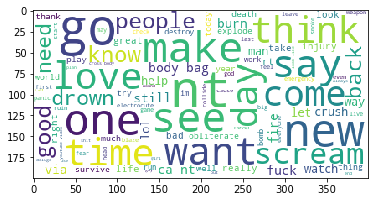

In [38]:
plotWordCloud(Updated_Text_Target0)

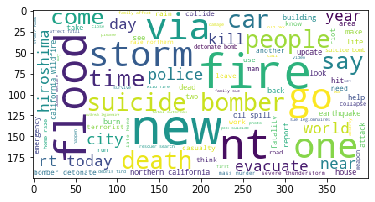

In [39]:
plotWordCloud(Updated_Text_Target1)

# Train Test Data Split

In [41]:
x_train,x_test,y_train,y_test=train_test_split(df_train['text'],df_train['target'],test_size=0.2,random_state=6)

In [42]:
x_train=pd.DataFrame(data=x_train,columns=['text'])
x_test=pd.DataFrame(data=x_test,columns=['text'])

In [43]:
x_train_vec = vectorizer.fit_transform(x_train['text'].values)
x_test_vec = vectorizer.transform(x_test['text'].values)

In [44]:
x_train['text'].values

array(['tip prevent basement leak create control joint eliminate random crack homeimprovement flooding',
       'jacksonville family band together memorial plan',
       'chpsre rt refugees follower paris visit dream humanity exhibition rezaphotography',
       ..., 'oryx symbol arabian peninsula annihilate hunter',
       'year atomic bomb japan still struggle war past anniversary devastation wrought',
       'think typhoon pass lol'], dtype=object)

In [45]:
print(vectorizer.get_feature_names())

['aa', 'aaaa', 'aaaaaaallll', 'aaaaaand', 'aaarrrgghhh', 'aaceorg', 'aan', 'aar', 'aaronthefm', 'aashiqui', 'ab', 'aba', 'abandon', 'abandonedpics', 'abbandoned', 'abbott', 'abbruchsimulator', 'abbswinston', 'abbyairshow', 'abc', 'abcnews', 'abe', 'aberdeen', 'aberdeenfanpage', 'aberdeenfc', 'aberystwythshrewsbury', 'abha', 'abia', 'ability', 'ablaze', 'able', 'ableg', 'abninfvet', 'aboard', 'abomb', 'abombed', 'abomination', 'abortion', 'abouts', 'abrancaballero', 'absence', 'absolute', 'absolutely', 'abstorm', 'abstract', 'abuse', 'abused', 'abuseddesolate', 'abysmaljoiner', 'ac', 'acaciapenn', 'acarewornheart', 'acc', 'accept', 'accepts', 'access', 'accident', 'accidentally', 'accidently', 'accionempresa', 'accord', 'accordingly', 'account', 'accuracy', 'accuse', 'accustom', 'acdelco', 'acebabes', 'acebreakingnews', 'acee', 'acenewsdesk', 'achedin', 'achieve', 'achievement', 'achimota', 'acid', 'acmilan', 'acoustic', 'acousticmaloley', 'acquire', 'acquisition', 'acre', 'acronym', 'a

# Model Selection

In [52]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import f_classif
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

#Using Naive Bayes

In [59]:
pipeline = Pipeline([
    ('bow',CountVectorizer()),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
#     ('selector',SelectPercentile(f_classif,percentile =80 )),
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [60]:

pipeline.fit(x_train['text'].values,y_train)
predictions = pipeline.predict(x_test['text'].values)
print(classification_report(predictions,y_test))
print(confusion_matrix(predictions,y_test))
print(accuracy_score(predictions,y_test))

              precision    recall  f1-score   support

           0       0.90      0.78      0.84      1005
           1       0.66      0.84      0.74       518

    accuracy                           0.80      1523
   macro avg       0.78      0.81      0.79      1523
weighted avg       0.82      0.80      0.80      1523

[[781 224]
 [ 83 435]]
0.7984241628365069


#Using Support Vector Machine 

In [53]:
pipeline = Pipeline([
    ('bow',CountVectorizer()),  
    ('tfidf', TfidfTransformer()), 
    ('selector',SelectPercentile(f_classif,percentile =80 )),
    ('classifier', SVC(kernel="rbf" , gamma=1)),  
])

In [54]:

pipeline.fit(x_train['text'].values,y_train)
predictions = pipeline.predict(x_test['text'].values)
print(classification_report(predictions,y_test))
print(confusion_matrix(predictions,y_test))
print(accuracy_score(predictions,y_test))

              precision    recall  f1-score   support

           0       0.90      0.78      0.84       994
           1       0.68      0.84      0.75       529

    accuracy                           0.80      1523
   macro avg       0.79      0.81      0.79      1523
weighted avg       0.82      0.80      0.81      1523

[[780 214]
 [ 84 445]]
0.804333552199606
